# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.functions import countDistinct as fcountDistinct
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import count as fcount
from pyspark.sql.functions import split
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf

from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time
import pandas as pd
import numpy as np

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Feature Creation") \
    .getOrCreate()

SO_data = 'mini_sparkify_event_data.json'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
spark

In [4]:
#loading dataset
df = spark.read.json(SO_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# checking dataframe dimensionality
num_rows = df.count()
num_columns = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 286500
Number of columns: 18


In [6]:
# checking dataframe schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# checking top 5 rows of dataframe
df_5 = df.take(5)
df_5

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
# converting Spark dataframe df_5 to Pandas dataframe df_pd
df_pd = pd.DataFrame(df_5, columns=df.columns)
df_pd

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


Verifying the presence of invalid or missing data, such as entries that are not properly filled in the variables userId or sessionId.

In [9]:
# Checking for null values in the dataframe of pyspark
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null # The output in dict where key is column name and value is null values in that column

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

In [10]:
# checking values that are null
null_count_dict = {column: df.filter(df[column].isNull()).count() for column in df.columns}

# Dictionary has keys and null value counts
null_count_dict

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

The userId and sessionId columns do not contain any NaN values. Nevertheless, a couple other columns shows a significant number of NaN values.

In [11]:
# checking for empty input in userId column
print(df.filter(df['userId']=='').count())

8346


There are 8346 values or rows with an empty userId.

In [12]:
# checking for empty input in sessionId column
print(df.filter(df['sessionId']=='').count())

0


There are 0 values or rows with an empty userId. which means that all rows has proper values.

Let's tidy up the Spark DataFrame by eliminating all entries that lack a userId.

In [13]:
cleaned_df = df.filter(df['userId']!='')

Validating removing NAN values from the cleaned spark dataframe. 

In [14]:
null_cleaned_dict = {col:cleaned_df.filter(cleaned_df[col].isNull()).count() for col in df.columns}
null_cleaned_dict

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

We've successfully diminished the count of NaNs by excluding rows lacking a valid userId. The cleansing process for 15 out of the 18 variables in the Spark DataFrame is now finished. Nevertheless, the variables artists, length, and song still exhibit a considerable number of NaNs. While one option is to remove all rows with NaNs in the Spark DataFrame, it comes with the risk of losing valuable information.

Let's inspect the records that display NaNs in the artists, length, and song variables.

In [15]:
# To enhance visibility, we present these records in a Pandas DataFrame.
df_pd = pd.DataFrame(cleaned_df.where("artist is null").take(50046), columns=cleaned_df.columns)
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50046 entries, 0 to 50045
Data columns (total 18 columns):
artist           0 non-null object
auth             50046 non-null object
firstName        50046 non-null object
gender           50046 non-null object
itemInSession    50046 non-null int64
lastName         50046 non-null object
length           0 non-null object
level            50046 non-null object
location         50046 non-null object
method           50046 non-null object
page             50046 non-null object
registration     50046 non-null int64
sessionId        50046 non-null int64
song             0 non-null object
status           50046 non-null int64
ts               50046 non-null int64
userAgent        50046 non-null object
userId           50046 non-null object
dtypes: int64(5), object(13)
memory usage: 6.9+ MB


All NaN values in the artists, length, and song variables are found in the same records. This suggests that these records may represent user interactions where no song was played.

Let's attempt to validate this hypothesis.

In [16]:
# Determine the count of unique elements.
df_pd.nunique()

artist               0
auth                 2
firstName          189
gender               2
itemInSession      859
lastName           173
length               0
level                2
location           114
method               2
page                18
registration       224
sessionId         2292
song                 0
status               3
ts               49696
userAgent           56
userId             224
dtype: int64

The entries containing NaNs in the artists, length, and song variables belong to a considerable number of unique users engaging with our service across various time points. It is advisable to retain these records as they constitute valid observations of user interactions, even if there is no music playback.

Moving forward, in the Spark DataFrame, we aim to convert the timestamp variable ts and the registration variable into two new variables, namely timeanddate and registration_timeanddate, respectively. Both variables should display the time and date in a human-readable string format.

Explanation:
The Unix timestamp is a method for representing time by measuring the total elapsed seconds since the Unix Epoch, which began on January 1st, 1970, at UTC. Consequently, the Unix timestamp indicates the number of seconds that have passed between a specific date and the Unix Epoch.

For further exploration and conversion of Unix timestamps, you can visit: Unix Timestamp Converter

### Creation of a New Variable 'formatted_datetime'
(String That Represents Date and Time)

The string variable displays the date and time of the user record.

In [17]:
# Defining a User Defined Function to convert Unix timestamps to string representation
convert_unix_to_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# Apply the User Defined Function to the 'ts' variable
cleaned_df = cleaned_df.withColumn("formatted_datetime", convert_unix_to_datetime(cleaned_df.ts))

In [18]:
# checking newly created column "formatted_datetime".
cleaned_df.describe('formatted_datetime').show()

+-------+-------------------+
|summary| formatted_datetime|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



### Creation of a New Variable 'formatted_registration_datetime' 
(String That Represents Date and Time)

The string variable indicates the date and time of the user's registration for the service.

In [19]:
# Applying the User Defined Function to convert Unix timestamps in the registration variable
cleaned_df = cleaned_df.withColumn("formatted_registration_datetime", convert_unix_to_datetime(cleaned_df.registration))

### Creation of a New Variable 'membership_duration_days' 
(int)

For each record, the numeric variable represents the count of days since the user registered for the service.

In [20]:
# Define a User Defined Function to calculate the duration in days
calculate_duration_days = udf(lambda x, y: float((x - y) / (1000 * 60 * 60 * 24)))

# Apply the User Defined Function to the 'ts' and 'registration' variables
cleaned_df = cleaned_df.withColumn("membership_duration_days", calculate_duration_days(cleaned_df.ts, cleaned_df.registration))
cleaned_df = cleaned_df.withColumn("membership_duration_days", cleaned_df["membership_duration_days"].cast(IntegerType()))

In [21]:
# print column types
cleaned_df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('formatted_datetime', 'string'),
 ('formatted_registration_datetime', 'string'),
 ('membership_duration_days', 'int')]

In [22]:
# Creating or replacing a temporary view for the cleaned DataFrame
cleaned_df.createOrReplaceTempView("cleaned_user_log_view")

Explore the distribution in membership duration in days among different users.

In [23]:
df_membership_duration = spark.sql(
        '''
        
        SELECT DISTINCT userId, MAX(membership_duration_days) AS membership_duration_days
        FROM cleaned_user_log_view
        GROUP BY userId
        
        '''
).toPandas().dropna()

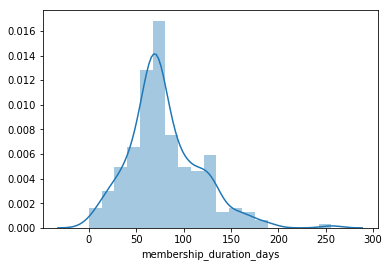

In [24]:
sns.distplot(df_membership_duration.membership_duration_days);

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### SQL Queries environment

The following code establishes a temporary view that enables the execution of SQL queries.

In [25]:
# Create a temporary view for running SQL queries
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [26]:
# Validating the status of the SQL view

spark.sql('''
        SELECT DISTINCT(*)
        FROM user_log_data_view
        LIMIT 5
''').show()

+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------+------+-------------+--------------------+------+-------------------+-------------------------------+------------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|          song|status|           ts|           userAgent|userId| formatted_datetime|formatted_registration_datetime|membership_duration_days|
+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------+------+-------------+--------------------+------+-------------------+-------------------------------+------------------------+
|          null|Logged In|     Alex|     M|           46|   Hogan|     null| free|Denver-Aurora-Lak...|   PUT|  Logout|1535066380000|      100|  

### Initial analysis

In [27]:
# Getting number of records in the dataset
spark.sql('''
          SELECT COUNT(*) AS num_of_recs
          FROM user_log_data_view
          '''
          ).show()

+-----------+
|num_of_recs|
+-----------+
|     278154|
+-----------+



In [28]:
# Confirm result using alternative approach.
num_of_recs = cleaned_df.distinct().count()
print("Number of records:", num_of_recs)

Number of records: 278154


In the limited subset of data under examination, there are 278,154 records.

now we are going to check the statistical summary of numrical variables in the dataset.

In [29]:
# Statistical summary for numerical variables 
stats_summ = spark.sql('''
        SELECT itemInSession, length, sessionId ,  status 
        FROM user_log_data_view
        ''').describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|     itemInSession|           length|         sessionId|            status|
+-------+------------------+-----------------+------------------+------------------+
|  count|            278154|           228108|            278154|            278154|
|   mean|114.89918174824018|249.1171819778458|1042.5616241362698|209.10321620397335|
| stddev|  129.851729399489|99.23517921058361| 726.5010362219813|30.151388851328214|
|    min|                 0|          0.78322|                 1|               200|
|    max|              1321|       3024.66567|              2474|               404|
+-------+------------------+-----------------+------------------+------------------+



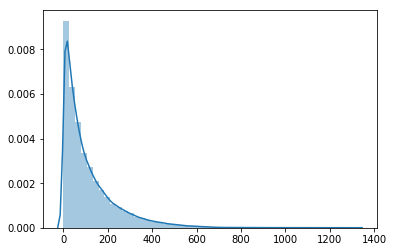

In [30]:
# Checking the ditribution of value in the variable itemInSession
itemInSession_dist = spark.sql(
        '''
        SELECT (itemInSession)
        FROM user_log_data_view
        ''')

IIS_Distplot = itemInSession_dist.toPandas().dropna()

sns.distplot(IIS_Distplot)

In [31]:
#Statistical summary
IIS_Distplot.describe()

,itemInSession
count,278154.000000
mean,114.899182
std,129.851729
min,0.000000
25%,27.000000
50%,70.000000
75%,157.000000
max,1321.000000


The variable itemInSession exhibits a pronounced positive skewness in its distribution.


The median, or 50th percentile, is 70 items, and the mean is approximately 115 items per session. Nevertheless, the notable positive skewness is indicative of the pattern where the variable itemInSession begins at 0 for every new user session and increments by one for each additional item in the session.

### length Variable
(type: Float, indicates: time in seconds)



Let's examine the distribution of the 'length' variable.







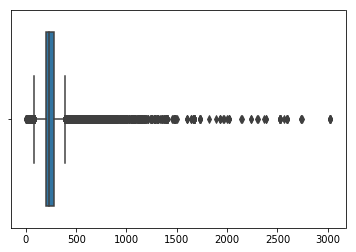

In [32]:
# Checking the ditribution of value in the variable length
length_dist = spark.sql(
        '''
        SELECT length
        FROM user_log_data_view
        ''').toPandas().dropna()

sns.boxplot(length_dist);

In [33]:
#Statistical summary for length
length_dist.describe()

,length
count,228108.000000
mean,249.117182
std,99.235179
min,0.783220
25%,199.888530
50%,234.500770
75%,277.158730
max,3024.665670


The distribution exhibits nearly symmetrical characteristics, showcasing a median of 234 seconds and a mean of 249 seconds. Nevertheless, the presence of substantial outliers is notable, with the maximum song length reaching 3025 seconds, equivalent to 50 minutes.

We need to provide information about the start and end dates of the records?

In [34]:
#start and end dates
spark.sql('''
          SELECT min(formatted_datetime) AS start, max(formatted_datetime) AS end
          FROM user_log_data_view
          '''
          ).collect()

[Row(start='2018-10-01 00:01:57', end='2018-12-03 01:11:16')]

The limited subset of the dataset spans approximately two months, encompassing data from October 1st to December 3rd, 2018.

As an illustration, we can explore all the entries for the user identified by (userId = 2).

In [35]:
# All record for userId =2
spark.sql('''
          SELECT firstname, lastname, page, formatted_datetime, itemInSession, registration
          FROM user_log_data_view 
          WHERE userID == '2'
          ORDER BY formatted_datetime ASC
          '''
          ).collect()

[Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 04:49:55', itemInSession=0, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 04:54:41', itemInSession=1, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 04:57:41', itemInSession=2, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 05:01:30', itemInSession=3, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 05:05:38', itemInSession=4, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 05:11:38', itemInSession=5, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', formatted_datetime='2018-10-08 

In [36]:
# Checking start and end date for userId=2
spark.sql('''
          SELECT min(formatted_datetime) AS start, max(formatted_datetime) AS end
          FROM user_log_data_view 
          WHERE userID == '2'
          '''
          ).collect()

[Row(start='2018-10-08 04:49:55', end='2018-11-21 22:30:04')]

In [37]:
# Selecting all pages that have been visited as Sparkify
spark.sql('''
          SELECT DISTINCT page
          FROM user_log_data_view 
          ORDER BY page ASC
          '''
          ).show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [38]:
# Number of male and female users in dataset.
spark.sql(
        '''
        SELECT gender,COUNT(DISTINCT userId) AS Number_of_users_by_G
        FROM user_log_data_view
        GROUP BY gender
        ORDER BY Number_of_users_by_G ASC
        '''
        ).show()

+------+--------------------+
|gender|Number_of_users_by_G|
+------+--------------------+
|     F|                 104|
|     M|                 121|
+------+--------------------+



total number of users = 225, females = 104, males = 121

In [39]:
# Number of free and paid users in dataset.
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS Number_of_users_by_L
        FROM user_log_data_view
        GROUP BY level
        ORDER BY Number_of_users_by_L DESC
''').show()


+-----+--------------------+
|level|Number_of_users_by_L|
+-----+--------------------+
| free|                 195|
| paid|                 165|
+-----+--------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [40]:
# Number of Canceled records in dataset.
spark.sql('''
        SELECT auth, COUNT(userId) AS Number_of_users_by_C
        FROM user_log_data_view
        GROUP BY auth
        ORDER BY Number_of_users_by_C DESC
        '''
         ).show()

+---------+--------------------+
|     auth|Number_of_users_by_C|
+---------+--------------------+
|Logged In|              278102|
|Cancelled|                  52|
+---------+--------------------+



total number of records = 278,154 , and with the help of auth variable it flagged 52 records as cancelled

In [41]:
# Number of users that visited page Cancellation Confirmation in dataset.

spark.sql('''
        SELECT page,COUNT(userId) AS Number_of_users_by_CC
        FROM user_log_data_view
        GROUP BY page
        ORDER BY Number_of_users_by_CC ASC
''').show()

+--------------------+---------------------+
|                page|Number_of_users_by_CC|
+--------------------+---------------------+
|              Cancel|                   52|
|Cancellation Conf...|                   52|
|    Submit Downgrade|                   63|
|      Submit Upgrade|                  159|
|               Error|                  252|
|       Save Settings|                  310|
|               About|                  495|
|             Upgrade|                  499|
|                Help|                 1454|
|            Settings|                 1514|
|           Downgrade|                 2055|
|         Thumbs Down|                 2546|
|              Logout|                 3226|
|         Roll Advert|                 3933|
|          Add Friend|                 4277|
|     Add to Playlist|                 6526|
|                Home|                10082|
|           Thumbs Up|                12551|
|            NextSong|               228108|
+---------

We need to check if the 52 records that visited page Cancellation Confirmation are the 52 records showing Cancelled in auth variable.

In [42]:
# validatin users between auth and page variables

Cancellation_group = spark.sql('''
          SELECT userId, auth, level, firstname, lastname, page, formatted_datetime, membership_duration_days
          FROM user_log_data_view 
          WHERE page == 'Cancellation Confirmation'
          ORDER BY  formatted_datetime DESC
          '''
         ).toPandas()

Cancellation_group

,userId,auth,level,firstname,lastname,page,formatted_datetime,membership_duration_days
0,100007,Cancelled,paid,Piper,Cook,Cancellation Confirmation,2018-11-29 11:45:09,115
1,100021,Cancelled,free,Rayden,Phillips,Cancellation Confirmation,2018-11-25 11:03:02,64
2,100015,Cancelled,paid,Tina,Thompson,Cancellation Confirmation,2018-11-24 15:35:53,67
3,300001,Cancelled,paid,Antonina,Kennedy,Cancellation Confirmation,2018-11-23 21:42:24,188
4,100014,Cancelled,paid,Rodrigo,Carey,Cancellation Confirmation,2018-11-20 19:04:09,85
5,53,Cancelled,paid,Sebastian,Wang,Cancellation Confirmation,2018-11-19 12:34:56,53
6,200020,Cancelled,free,Keegan,Rivera,Cancellation Confirmation,2018-11-17 16:40:42,75
7,200016,Cancelled,free,Charlotte,Frazier,Cancellation Confirmation,2018-11-16 08:17:58,55
8,200017,Cancelled,paid,James,Dickerson,Cancellation Confirmation,2018-11-15 20:16:43,60
9,70,Cancelled,paid,Chayse,Keller,Cancellation Confirmation,2018-11-14 22:34:27,145


In [43]:
Cancellation_group["membership_duration_days"] = pd.to_numeric(Cancellation_group["membership_duration_days"])

Cancellation_group["membership_duration_days"].describe()

count     52.000000
mean      56.807692
std       36.602817
min        5.000000
25%       30.500000
50%       50.500000
75%       73.500000
max      188.000000
Name: membership_duration_days, dtype: float64

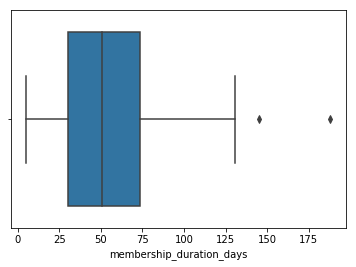

In [44]:
# Box plotting
sns.boxplot(Cancellation_group["membership_duration_days"])

In [45]:
# User Defined Function for detecting the churn events (1 for 'Cancellation Confirmation', 0 otherwise)
detect_churn_event = udf(lambda page: 1 if page == 'Cancellation Confirmation' else 0, IntegerType())

# Create a binary churn_event variable of type integer
cleaned_df = cleaned_df.withColumn('churn_event', detect_churn_event('page'))

In [46]:
# Statiscal Summary for churn_event
cleaned_df.describe('churn_event').show()

+-------+--------------------+
|summary|         churn_event|
+-------+--------------------+
|  count|              278154|
|   mean|1.869467992550889E-4|
| stddev|0.013671595449116164|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



In [47]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [48]:
#Checking churn_event records
spark.sql('''
          SELECT userId, auth, level, firstname, lastname, page, formatted_datetime, churn_event
          FROM user_log_data_view 
          WHERE churn_event == 1
          ORDER BY  formatted_datetime DESC
          '''
         ).show(50)

+------+---------+-----+---------+---------+--------------------+-------------------+-----------+
|userId|     auth|level|firstname| lastname|                page| formatted_datetime|churn_event|
+------+---------+-----+---------+---------+--------------------+-------------------+-----------+
|100007|Cancelled| paid|    Piper|     Cook|Cancellation Conf...|2018-11-29 11:45:09|          1|
|100021|Cancelled| free|   Rayden| Phillips|Cancellation Conf...|2018-11-25 11:03:02|          1|
|100015|Cancelled| paid|     Tina| Thompson|Cancellation Conf...|2018-11-24 15:35:53|          1|
|300001|Cancelled| paid| Antonina|  Kennedy|Cancellation Conf...|2018-11-23 21:42:24|          1|
|100014|Cancelled| paid|  Rodrigo|    Carey|Cancellation Conf...|2018-11-20 19:04:09|          1|
|    53|Cancelled| paid|Sebastian|     Wang|Cancellation Conf...|2018-11-19 12:34:56|          1|
|200020|Cancelled| free|   Keegan|   Rivera|Cancellation Conf...|2018-11-17 16:40:42|          1|
|200016|Cancelled| f

Subsequently, our goal is to introduce a new variable, "Churn," that signifies all records of users who eventually cancel the service. We can achieve this by utilizing a SQL window function to obtain the maximum value of the variable "churn_event" for each userId.

In [49]:
# SQl query utilizing window function
spark.sql('''
          SELECT userId, max(churn_event)
          OVER (PARTITION BY userID)
          FROM user_log_data_view 
          ORDER BY  formatted_datetime 
          '''
         ).show(30)

+------+----------------------------------------------------------------------------------------------------+
|userId|max(churn_event) OVER (PARTITION BY userID ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)|
+------+----------------------------------------------------------------------------------------------------+
|    30|                                                                                                   0|
|     9|                                                                                                   0|
|    30|                                                                                                   0|
|     9|                                                                                                   0|
|    30|                                                                                                   0|
|     9|                                                                                                   0|
|     9|  

We will utilize the PySpark SQL function Window to partition the Spark DataFrame by userId, similar to the SQL query performed earlier, without constraints on the number of rows (i.e., ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING).

In [50]:
window_userId = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

To create a new churn column we will apply the Window function in pyspark sql, by taking the maximum value of churn event for every userId

In [51]:
cleaned_df = cleaned_df.withColumn('churn',fmax('churn_event').over(window_userId))

In [52]:
# Statitical Summary for churn
cleaned_df.describe('churn').show()

+-------+-------------------+
|summary|              churn|
+-------+-------------------+
|  count|             278154|
|   mean|0.16129194618808287|
| stddev|0.36780068056308857|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



almost 16% of records in the limited subset of the dataset are users who churned

In [53]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

### Events of Downgrading Accounts

In [54]:
# Checking Downgrading of accounts events
spark.sql('''
          SELECT COUNT(DISTINCT userId) as downgrading_events_users
          FROM user_log_data_view
          WHERE page == 'Downgrade'
          '''
         ).show()

+------------------------+
|downgrading_events_users|
+------------------------+
|                     154|
+------------------------+



In [55]:
# Comparing to total number of users
spark.sql('''
          SELECT COUNT(DISTINCT userId) as Total_Users
          FROM user_log_data_view 
          '''
         ).show()

+-----------+
|Total_Users|
+-----------+
|        225|
+-----------+



68% of users went to the downgrade page, but how many users actually went through with the downgrade?

In [56]:
# Users that went through with the downgrade
spark.sql('''
          SELECT COUNT(DISTINCT userId) As number_of_users_went_through_downgrade
          FROM user_log_data_view 
          WHERE page == 'Submit Downgrade'
         
          '''
         ).show()

+--------------------------------------+
|number_of_users_went_through_downgrade|
+--------------------------------------+
|                                    49|
+--------------------------------------+



In [57]:
# Number of users who downgrade and churn the service in the end
spark.sql('''
          SELECT Churn, COUNT(DISTINCT userId) AS did_downgrade
          FROM user_log_data_view 
          WHERE page == 'Submit Downgrade' 
          GROUP BY Churn
          '''
         ).show()

+-----+-------------+
|Churn|did_downgrade|
+-----+-------------+
|    1|            9|
|    0|           40|
+-----+-------------+



In [58]:
spark.sql('''
          SELECT DISTINCT userId, page, Churn, level
          FROM user_log_data_view 
          WHERE page == 'Submit Downgrade' OR page == 'Cancellation Confirmation'
          ORDER BY userId
         
          '''
         ).show(50)

+------+--------------------+-----+-----+
|userId|                page|Churn|level|
+------+--------------------+-----+-----+
|   100|    Submit Downgrade|    0| paid|
|100001|Cancellation Conf...|    1| free|
|100003|Cancellation Conf...|    1| free|
|100004|    Submit Downgrade|    0| paid|
|100005|Cancellation Conf...|    1| free|
|100006|Cancellation Conf...|    1| free|
|100007|Cancellation Conf...|    1| paid|
|100008|    Submit Downgrade|    0| paid|
|100009|    Submit Downgrade|    1| paid|
|100009|Cancellation Conf...|    1| free|
|100011|Cancellation Conf...|    1| free|
|100012|    Submit Downgrade|    1| paid|
|100012|Cancellation Conf...|    1| free|
|100013|Cancellation Conf...|    1| paid|
|100014|Cancellation Conf...|    1| paid|
|100015|Cancellation Conf...|    1| paid|
|100015|    Submit Downgrade|    1| paid|
|100016|    Submit Downgrade|    0| paid|
|100017|Cancellation Conf...|    1| free|
|100018|    Submit Downgrade|    0| paid|
|100019|Cancellation Conf...|    1

Explore the instances when users downgrade their accounts and subsequently mark those log entries. Employing a Window function and cumulative sum, we differentiate each user's data into pre or post-downgrade events.

In [59]:
cleaned_df.filter("page = 'Submit Downgrade'").show(5)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------------------+------------------------+-----------+-----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId| formatted_datetime|formatted_registration_datetime|membership_duration_days|churn_event|churn|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+-------------------------------+------------------------+-----------+-----+
|  null|Logged In|    Alexi|     F|           41|   Warren|  null| paid|Spokane-Spokane V...|   PUT|Submit Downgrade|1532482662

In [60]:
cleaned_df.select(["userId", "firstname", "page", "level", "song"]).where(cleaned_df.userId == "100").collect()

[Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Bring Me To Life'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Strut (1993 Digital Remaster)'),
 Row(userId='100', firstname='Colin', page='Thumbs Down', level='paid', song=None),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Pretty Little Angel'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='City On Our Knees'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Monday Morning (LP Version)'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Your Place [Album Version]'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Shoulder Lean [Featuring T.I.] (Amended Album Version) (AKA Radio Version)'),
 Row(userId='100', firstname='Colin', page='Add to Playlist', level='paid', song=None),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid'

In [61]:
downgrade_flagged_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
cleaned_df = cleaned_df.withColumn("downgrade_event", downgrade_flagged_event("page"))

cleaned_df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', formatted_datetime='2018-11-21 18:12:32', formatted_registration_datetime='2018-09-27 02:45:40', membership_duration_days=55, churn_event=0, churn=0, downgrade_event=0)

### Creation of a New Variable 'phase'
(Integer)

The numeric variable denotes the count of times a user has downgraded the service. This variable maintains a consistent value across all records for a particular user.

In [62]:
# adding 'phase' variable
cleaned_df = cleaned_df.withColumn("phase", fsum("downgrade_event").over(window_userId))

In [63]:
cleaned_df.select(["firstname", "formatted_datetime", "page", "level", "downgrade_event", "phase"])\
           .where(cleaned_df.userId == "13")\
           .sort("ts").collect()

[Row(firstname='Anika', formatted_datetime='2018-10-01 05:38:09', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:45:46', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:48:39', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:50:53', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:51:20', page='Add to Playlist', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:53:26', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:55:44', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', formatted_datetime='2018-10-01 05:55:45', page='Logout', level='free', downgrade_event=

In [64]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [65]:
# Checking new variable "phase" distribution

spark.sql('''
        SELECT Churn, phase, COUNT(DISTINCT userId) AS no_of_users_PH
        FROM user_log_data_view
        GROUP BY Churn , phase 
        ORDER BY Churn ASC, phase ASC
        ''').show()

+-----+-----+--------------+
|Churn|phase|no_of_users_PH|
+-----+-----+--------------+
|    0|    0|           133|
|    0|    1|            28|
|    0|    2|            10|
|    0|    3|             2|
|    1|    0|            43|
|    1|    1|             9|
+-----+-----+--------------+



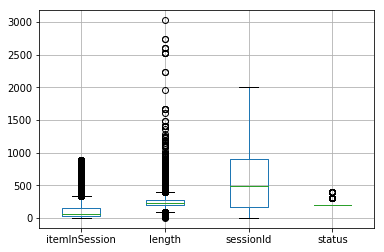

In [66]:
# Distribution of the numerical variables for users who churned the service
users_churn_num = spark.sql('''
        SELECT userId, itemInSession, length, sessionId ,  status 
        FROM user_log_data_view
        WHERE Churn == 1
        ''').toPandas()

# Box plotting users_churn_num
users_churn_num.boxplot();

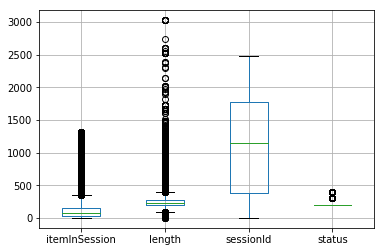

In [67]:
# Distribution of the numerical variables for users who didn't churned the service
users_no_churn_num = spark.sql('''
        SELECT userId, itemInSession, length, sessionId ,  status 
        FROM user_log_data_view
        WHERE Churn == 0
        ''').toPandas()

# Box plotting users_no_churn_num
users_no_churn_num.boxplot();

In [68]:
# Checking difference in statistical summary between with and without churn
(users_no_churn_num.describe() - users_churn_num.describe())

,itemInSession,length,sessionId,status
count,188426.000000,155320.000000,188426.000000,188426.000000
mean,6.755853,0.576340,511.793638,0.173109
std,8.428961,-3.759094,220.497172,0.331602
min,0.000000,-3.265310,0.000000,0.000000
25%,1.000000,0.548570,206.000000,0.000000
50%,5.000000,0.757560,654.000000,0.000000
75%,12.000000,1.528163,871.000000,0.000000
max,432.000000,0.000000,471.000000,0.000000


Users who choose to continue the service generally exhibit more active engagement. On average, these continuing users listen to a higher number of songs per session (itemInSession) and participate in more sessions over time (sessionId). Conversely, there is no notable distinction between the two groups in terms of song duration (length) or the status codes of their HTTP requests (e.g., Bad Request 400 Error).

In [69]:
# Statistical Summary for no churn
users_no_churn_num.describe()

,itemInSession,length,sessionId,status
count,233290.000000,191714.000000,233290.000000,233290.000000
mean,115.988847,249.209135,1125.109816,209.131137
std,131.150670,98.625883,732.553850,30.204613
min,0.000000,0.783220,1.000000,200.000000
25%,27.000000,199.940770,377.000000,200.000000
50%,71.000000,234.657510,1150.000000,200.000000
75%,159.000000,277.158730,1775.000000,200.000000
max,1321.000000,3024.665670,2474.000000,404.000000


### Creation of a New Variable 'items_number'
(Integer)

it shows the total number of user interactions of a single user.

In [70]:
# adding 'items_number' variable
cleaned_df = cleaned_df.withColumn("items_number", fcount ("itemInSession").over(window_userId))

In [71]:
cleaned_df.select(["itemInSession", "formatted_datetime", "page", ("sessionId") , "items_number"])\
           .where(cleaned_df.userId == "2")\
           .sort("ts").collect()

[Row(itemInSession=0, formatted_datetime='2018-10-08 04:49:55', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=1, formatted_datetime='2018-10-08 04:54:41', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=2, formatted_datetime='2018-10-08 04:57:41', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=3, formatted_datetime='2018-10-08 05:01:30', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=4, formatted_datetime='2018-10-08 05:05:38', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=5, formatted_datetime='2018-10-08 05:11:38', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=6, formatted_datetime='2018-10-08 05:15:37', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=7, formatted_datetime='2018-10-08 05:18:30', page='NextSong', sessionId=1, items_number=899),
 Row(itemInSession=8, formatted_datetime='2018-10-08 05:20:04', page='NextSong', sessionId=1, it

In [72]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Variable "auth"
Can take (Logged In/ Cancelled)

In [73]:
cleaned_df.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Cancelled|   51|
|    1|Logged In|    1|
+-----+---------+-----+



### Variable "gender"
Can take (M/ F)

In [74]:
spark.sql('''
          SELECT Churn, gender, COUNT(DISTINCT userId) AS No_of_Users_G
          FROM user_log_data_view 
          GROUP BY Churn, gender
          ORDER BY Churn DESC, gender
         
          '''
         ).show()

+-----+------+-------------+
|Churn|gender|No_of_Users_G|
+-----+------+-------------+
|    1|     F|           20|
|    1|     M|           32|
|    0|     F|           84|
|    0|     M|           89|
+-----+------+-------------+



I will try to implement a statistical prportions test to see if males cancel the service as much as females using the null hypothesis.

In [75]:
# Perform a proportions z-test

# Number of successes in trials
counting = np.array([20, 32])

# Number of trials or observations
trials = np.array([(20 + 84), (32 + 89)])

# Conduct z-test for proportions
test_stat, p_value = proportions_ztest(counting, trials, value=None, alternative='two-sided', prop_var=False)

# Display the test statistic for the z-test
print('z-test test statistic = {0:0.2f}'.format(test_stat))

# Display the p-value for the z-test
print('z-test p-value = {0:0.3f}'.format(p_value))

z-test test statistic = -1.28
z-test p-value = 0.201


We fail to reject the null hypothesis indicating that gender does not significantly affect churn probability, as the high p-value of 0.201 suggests. There is a 20 percent probability of obtaining the observed statistic or a more extreme one in favor of the alternative hypothesis.

### Variable "length"
(in seconds)

In [76]:
#checking the relationship of churn and length
spark.sql('''
          SELECT Churn, AVG(length), MIN(length), 
                 MAX(length), SUM(length)
          FROM user_log_data_view 
          GROUP BY Churn
          ORDER BY Churn DESC
         
          '''
         ).show()

+-----+------------------+-----------+-----------+-------------------+
|Churn|       avg(length)|min(length)|max(length)|        sum(length)|
+-----+------------------+-----------+-----------+-------------------+
|    1| 248.6327956440622|    4.04853| 3024.66567|      9048741.96467|
|    0|249.20913538880808|    0.78322| 3024.66567|4.777688018192995E7|
+-----+------------------+-----------+-----------+-------------------+



The variable "length" does not influence the churn variable. There is minimal difference in the average song length between both groups of users.

### Variable "level"
Can take (free/ paid)

In [77]:
#checking the relationship of churn and level
spark.sql('''
        SELECT Churn, level,COUNT(DISTINCT userId) AS No_of_Users_L
        FROM user_log_data_view
        GROUP BY Churn, level
        ORDER BY No_of_Users_L DESC
''').show()

+-----+-----+-------------+
|Churn|level|No_of_Users_L|
+-----+-----+-------------+
|    0| free|          149|
|    0| paid|          129|
|    1| free|           46|
|    1| paid|           36|
+-----+-----+-------------+



In [78]:
# Perform a proportions z-test

# Number of successes in trials
counting = np.array([46, 36])

# Number of trials or observations
trials = np.array([(46 + 149), (36 + 128)])

# Conduct z-test for proportions
test_stat, p_value = proportions_ztest(counting, trials, value=None, alternative='two-sided', prop_var=False)

# Display the test statistic for the z-test
print('z-test test statistic = {0:0.2f}'.format(test_stat))

# Display the p-value for the z-test
print('z-test p-value = {0:0.3f}'.format(p_value))

z-test test statistic = 0.37
z-test p-value = 0.713


The categorical variable "level" does not demonstrate a statistically significant influence on churn. As a result, we cannot reject the null hypothesis, indicating that both groups of users share an equal likelihood of churning the service.

### Variable "method"
Can take (PUT/ GET)

In [79]:
#checking the relationship of churn and method

spark.sql('''
        SELECT Churn, method,COUNT(userId) AS rows_no
        FROM user_log_data_view
        GROUP BY method, Churn
        ORDER BY rows_no DESC
''').show()

+-----+------+-------+
|Churn|method|rows_no|
+-----+------+-------+
|    0|   PUT| 216691|
|    1|   PUT|  41127|
|    0|   GET|  16599|
|    1|   GET|   3737|
+-----+------+-------+



In [80]:
# Calculate the ratio of records with the GET method for all users
ratio_method_all_users = ((16599 + 3737) / 278154) * 100

# Display the calculated ratio
print('Ratio of records for GET method "all users" is {0:0.1f} percent.'.format(ratio_method_all_users))

Ratio of records for GET method "all users" is 7.3 percent.


In [81]:
# Calculate the ratio of records with the GET method for active users
ratio_method_active = (16599) /(16599+216691)*100

# Display the calculated ratio
print('Ratio of records for GET method "active" is {0:0.1f} percent.'.format(ratio_method_active))

Ratio of records for GET method "active" is 7.1 percent.


In [82]:
# Calculate the ratio of records with the GET method for churned users
ratio_method_churned = (3737) /(3737+41127)*100

# Display the calculated ratio
print('Ratio of records for GET method "churned" is {0:0.1f} percent.'.format(ratio_method_churned))

Ratio of records for GET method "churned" is 8.3 percent.


In [83]:
# Perform a proportions z-test

# Number of successes in trials
counting = np.array([3737, 16599])

# Number of trials or observations
trials = np.array([(3737+41127), (16599+216691)])

# Conduct z-test for proportions
test_stat, p_value = proportions_ztest(counting, trials, value=None, alternative='two-sided', prop_var=False)

# Display the test statistic for the z-test
print('z-test test statistic = {0:0.2f}'.format(test_stat))

# Display the p-value for the z-test
print('z-test p-value = {0:0.3f}'.format(p_value))

z-test test statistic = 9.05
z-test p-value = 0.000


The obtained p-value is statistically significant, falling below the conventional threshold of significance (usually p < 0.05). Rejecting the null hypothesis implies evidence supporting a relationship between Churn and method. However, it's essential to understand that the p-value's significance is based on the assumption that the null hypothesis is true and does not provide a probability of the alternative hypothesis being true.



The null hypothesis posits no relationship between Churn and method, attributing the results to chance without substantial support for the investigated idea. Conversely, the alternative hypothesis suggests that the independent variable Churn does have a significant impact on the dependent variable method, with results considered noteworthy in supporting the theory.

It's important to note that achieving statistical significance does not necessarily translate to practical significance.

### Variable "Artist "
(String) 

Name of artist playing variable "song"

In [84]:
# checking number of unique Artists (non duplicated)
spark.sql('''
        SELECT COUNT(DISTINCT Artist)
        FROM user_log_data_view 
        '''
        ).show()

+----------------------+
|count(DISTINCT Artist)|
+----------------------+
|                 17655|
+----------------------+



In [85]:
# Retrieve the count of songs played by the most frequently played artist among churn users
most_played_artist_churn = spark.sql('''
        SELECT Artist, COUNT(Artist) AS Users_churned 
        FROM user_log_data_view 
        WHERE Churn == 1
        GROUP BY Artist 
        ORDER BY Users_churned DESC 
        
        '''
        ).toPandas()

In [86]:
# Retrieve the count of songs played by the most frequently played artist among active users
most_played_artist_active = spark.sql('''
        SELECT Artist, COUNT(Artist) AS users_active
        FROM user_log_data_view 
        WHERE Churn == 0
        GROUP BY Artist 
        ORDER BY users_active DESC 
        '''
        ).toPandas()

In [87]:
# Set the 'Artist' column as the index for better readability and analysis
most_played_artist_churn = most_played_artist_churn.set_index('Artist')
most_played_artist_active = most_played_artist_active.set_index('Artist')

In [88]:
# Concatenate DataFrames for active and churned users, grouping by 'Artist' and summing the counts
combined_artist_data = pd.concat([most_played_artist_active.groupby('Artist').sum(), most_played_artist_churn.groupby('Artist').sum()], \
                              axis=1, join="outer", sort=True)

In [89]:
# Sort the combined artist DataFrame by the number of active and churned users in descending order
combined_artist_data = combined_artist_data.sort_values(by=['users_active', 'Users_churned'], ascending=False)

In [90]:
# Select the top 50 records from the sorted combined artist DataFrame
combined_artist_data = combined_artist_data.head(50)

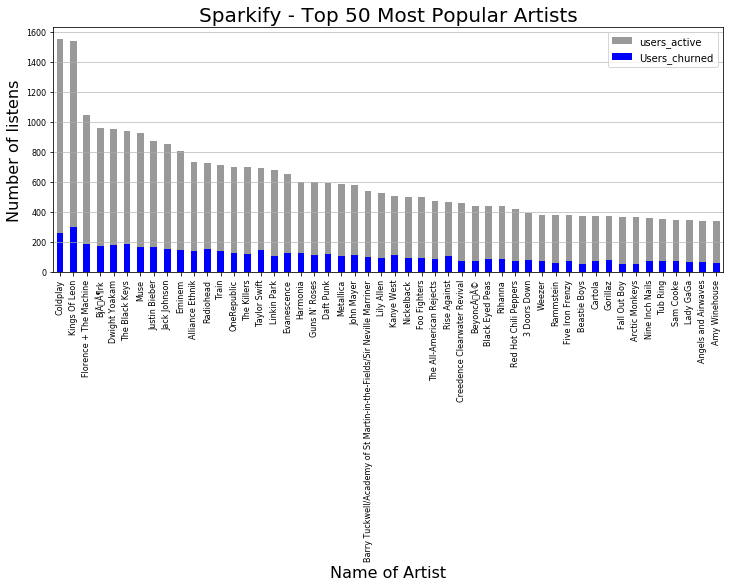

In [91]:
# Customize and display the bar plot for the most popular artists on Sparkify
plt.title('Sparkify - Top 50 Most Popular Artists', fontsize=20)

ax = combined_artist_data['users_active'].plot(kind='bar', color='0.6', figsize=(12, 4.5), legend=True, fontsize=10)
ax = combined_artist_data['Users_churned'].plot(kind='bar', color='b', legend=True, fontsize=8)
ax.set_xlabel("Name of Artist", fontsize=16)
ax.set_ylabel("Number of listens", fontsize=16)
plt.grid(axis='y', alpha=0.8)
plt.show()

Active and churned users share common preferences in the artists they listen to.

In [92]:
# Alternative approach: Retrieve the artist play counts using Spark SQL
artist_listen_counts = spark.sql("SELECT Artist, COUNT(Artist) AS listens \
        FROM user_log_data_view \
        GROUP BY Artist")

artist_listen_counts.show()

+--------------------+-------+
|              Artist|listens|
+--------------------+-------+
|      The Black Keys|   1125|
|         Silverstein|     60|
|           Kate Nash|     99|
|        Yann Tiersen|    139|
|    Jane's Addiction|     68|
|          Tim Hughes|     39|
|          Carl Craig|      3|
|Dashboard Confess...|     98|
|Yonder Mountain S...|     63|
|           Los Lobos|     45|
|Pete Rock & C.L. ...|      2|
|        Ziggy Marley|     28|
|      Jarabe De Palo|     83|
|               Rufio|     13|
|WC And The Maad C...|      1|
|      Jorge Gonzalez|     24|
|                Silk|     22|
|  The Watts Prophets|      6|
|            La Shica|      2|
|        Generation X|     19|
+--------------------+-------+
only showing top 20 rows



In [93]:
# Save the artist play counts in a new temporary view
artist_listen_counts.createOrReplaceTempView("no_of_listens")

In [94]:
# Perform a self join to identify the artist(s) with the maximum play count
spark.sql('''
          SELECT t2.Artist, t2.listens 
          FROM (SELECT max(listens) AS max_listens FROM no_of_listens) AS t1 
          JOIN no_of_listens AS t2 
          ON t1.max_listens = t2.listens 
          '''
          ).show()

+-------------+-------+
|       Artist|listens|
+-------------+-------+
|Kings Of Leon|   1841|
+-------------+-------+



What is the average number of songs played by active users before they navigate to the home page?

In [95]:
# Identify whether each user interaction corresponds to a home page visit
user_at_home = spark.sql('''
            SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS user_at_home 
            FROM user_log_data_view 
            WHERE ((page = 'NextSong') OR (page = 'Home')) AND Churn == 0
            '''
            )

In [96]:
# Save the results in a new temporary view
user_at_home.createOrReplaceTempView("user_at_home_table")

In [97]:
# Calculate cumulative sum for the user_at_home
c_sum = spark.sql('''
            SELECT * , SUM(user_at_home) 
            OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period 
            FROM user_at_home_table
            '''
            )

In [98]:
# Save the results in a new temporary view
c_sum.createOrReplaceTempView("c_sum_table")

In [99]:
# Calculate average of 'NextSong' for active users
spark.sql('''
          SELECT AVG(no_c) AS avg_songs_actv_usrs
          FROM (SELECT COUNT(*) AS no_c FROM c_sum_table \
          GROUP BY userID, period, page HAVING page = 'NextSong') AS counts
          '''
          ).show()

+-------------------+
|avg_songs_actv_usrs|
+-------------------+
| 23.768162658070914|
+-------------------+



What is the average number of songs played by churned users before they navigate to the home page?

In [100]:
# Identify whether each user interaction corresponds to a home page visit
user_at_home = spark.sql('''
            SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS user_at_home 
            FROM user_log_data_view 
            WHERE ((page = 'NextSong') OR (page = 'Home')) AND Churn == 1
            '''
            )

In [101]:
# Save the results in a new temporary view
user_at_home.createOrReplaceTempView("user_at_home_table")

In [102]:
# Calculate cumulative sum for the user_at_home
c_sum = spark.sql('''
            SELECT * , SUM(user_at_home) 
            OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period 
            FROM user_at_home_table
            '''
            )

In [103]:
# Save the results in a new temporary view
c_sum.createOrReplaceTempView("c_sum_table")

In [104]:
# Calculate average of 'NextSong' for churned users
spark.sql('''
          SELECT AVG(no_c) AS avg_songs_chrn_usrs
          FROM (SELECT COUNT(*) AS no_c FROM c_sum_table \
          GROUP BY userID, period, page HAVING page = 'NextSong') AS counts
          '''
          ).show()

+-------------------+
|avg_songs_chrn_usrs|
+-------------------+
|  22.67538940809969|
+-------------------+



### Creation of a New Variables 'city' & 'state'
(String)
by splitting "location" variable

The variable "location" is a categorical feature representing the municipality and U.S. state where users are located. It encompasses a diverse range of possibilities, including city names and U.S. states. Our primary interest lies in aggregating user counts based on their respective states.

In [105]:
# Split 'location' column into 'city' and 'state' columns using a comma as the delimiter
cleaned_df = cleaned_df.withColumn('city', split(df['location'], ",").getItem(0))\
        .withColumn('state', split(cleaned_df['location'], ",").getItem(1))

In [106]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

#show columns
cleaned_df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, formatted_datetime: string, formatted_registration_datetime: string, membership_duration_days: int, churn_event: int, churn: int, downgrade_event: int, phase: bigint, items_number: bigint, city: string, state: string]

In [107]:
# Aggregating active user counts based on state
by_state_active = spark.sql('''
        SELECT state, COUNT(DISTINCT userId) AS users_active
        FROM user_log_data_view
        WHERE Churn = 0
        GROUP BY state
        ORDER BY users_active DESC
        '''
).toPandas()

In [108]:
# Aggregating churned user counts based on state
by_state_churn = spark.sql('''
        SELECT state, COUNT(DISTINCT userId) AS users_churn
        FROM user_log_data_view
        WHERE Churn = 1
        GROUP BY state
        ORDER BY users_churn DESC
        '''
).toPandas()

In [109]:
# Setting the state as the index for active and churn dataframes
by_state_active = by_state_active.set_index('state')
by_state_churn = by_state_churn.set_index('state')

In [110]:
# Concatenating the location dataframes based on state
loc_by_state = pd.concat([by_state_churn.groupby('state').sum(), by_state_active.groupby('state').sum()], \
                              axis=1, join="outer", sort=True)

In [111]:
# Sorting the location by state dataframe based on active and churned users
loc_by_state = loc_by_state.sort_values(by=['users_active', 'users_churn'], ascending=False)

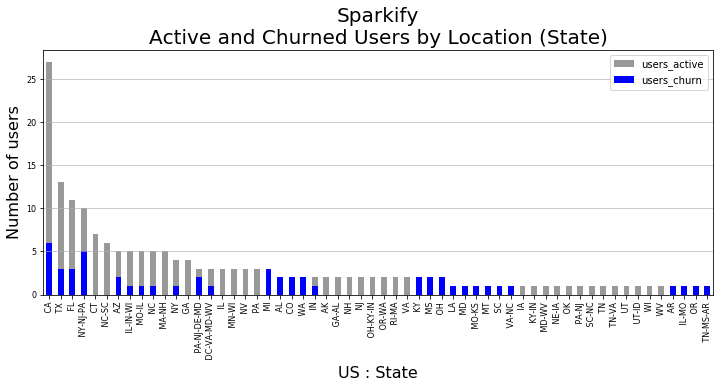

In [112]:
# Plotting the distribution of active and churned users by location (state)
plt.title('Sparkify\nActive and Churned Users by Location (State)', fontsize=20)

ax = loc_by_state['users_active'].plot(kind='bar', color ='0.6', figsize=(12, 4.5), legend=True, fontsize=10)
ax = loc_by_state['users_churn'].plot(kind='bar', color ='b', legend=True, fontsize=8)
ax.set_xlabel("US : State", fontsize=16)
ax.set_ylabel("Number of users", fontsize=16)
plt.grid(axis='y', alpha = 0.8)
plt.show()


The majority of Sparkify's user base resides in highly populated states. In this limited dataset, Sparkify exhibits a lower churn rate in states like California (CA), Texas (TX), and Florida (FL) compared to the overall churn rate of 52 out of 225, equivalent to 23 percent. However, Sparkify's churn rate is notably higher in some less populated states across the country.

### Variable "page "
(String) 

Name of page from the website of Sparkify that user visited.

In [113]:
# Count the number of records for each page type, grouped by churn status
no_of_pages = spark.sql('''
        SELECT page, Churn, COUNT(page) AS no_of_rcrds_P
        FROM user_log_data_view
        GROUP BY Churn, page
        ORDER BY page DESC
        '''
        ).toPandas()

In [114]:
# Separate the page count data for churn and active users
no_of_pages_actv = no_of_pages[no_of_pages.Churn == 0]
no_of_pages_actv = no_of_pages_actv.rename(columns={"no_of_rcrds_P": "users_active"})
no_of_pages_actv = no_of_pages_actv.drop(['Churn'], axis=1)
no_of_pages_actv = no_of_pages_actv.set_index('page')   

no_of_pages_chrn = no_of_pages[no_of_pages.Churn == 1]
no_of_pages_chrn = no_of_pages_chrn.rename(columns={"no_of_rcrds_P": "Users_churned"})
no_of_pages_chrn = no_of_pages_chrn.drop(['Churn'], axis=1)
no_of_pages_chrn = no_of_pages_chrn.set_index('page') 

# Combine the page count data for churn and active users
pages_df = pd.concat([no_of_pages_actv, no_of_pages_chrn], axis=1, join="inner")

# show dataframe
pages_df

,users_active,Users_churned
page,,
Upgrade,387,112
Thumbs Up,10692,1859
Thumbs Down,2050,496
Submit Upgrade,127,32
Submit Downgrade,54,9
Settings,1244,270
Save Settings,252,58
Roll Advert,2966,967
NextSong,191714,36394


In [115]:
# Sort the page count dataframe
pages_df = pages_df.sort_values(by=['users_active', 'Users_churned'], ascending=True)

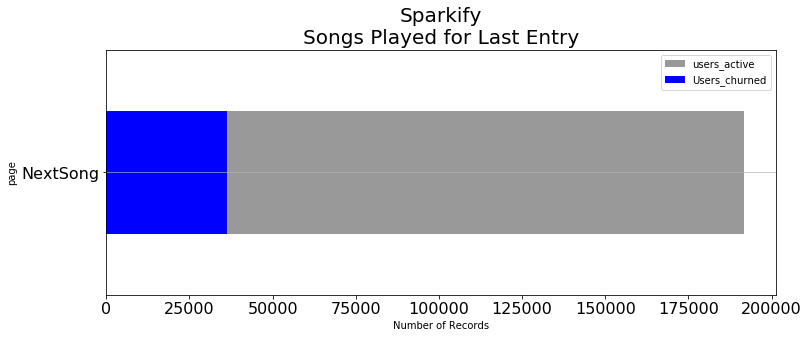

In [116]:
# Plot the number of records for the last entry in the DataFrame
plt.title('Sparkify\nSongs Played for Last Entry', fontsize=20)
plt.grid(True)

# Plotting the active users and churned users
ax = pages_df['users_active'].tail(1).plot(kind='barh', color ='0.6', figsize=(12, 4.5), legend=True, fontsize=10)
ax = pages_df['Users_churned'].tail(1).plot(kind='barh', color ='b', legend=True, fontsize=16)

ax.set_xlabel("Number of Records", fontsize=10)
plt.grid(axis='y', alpha=0.8)
plt.show()

What is the average number of songs played by churned users before they cancel Sparkify service?

In [117]:
# Filter the data for users who churned and pages related to cancellation confirmation
conf_cancel_events = spark.sql('''
            SELECT userID, page, ts, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS user_at_home
            FROM user_log_data_view 
            WHERE ((page = 'NextSong') OR (page = 'Cancellation Confirmation')) AND Churn == 1
            '''
)

In [118]:
# Save the results in a new temporary view
conf_cancel_events.createOrReplaceTempView("conf_cancel_events_table")

In [119]:
# Calculate cumulative sum
c_sum = spark.sql('''
            SELECT * , SUM(user_at_home) 
            OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period 
            FROM conf_cancel_events_table
            '''
            )

In [120]:
# Save the results in a new temporary view
c_sum.createOrReplaceTempView("c_sum_table")

In [121]:
# Calculate average of 'NextSong' for churned users
spark.sql('''
          SELECT AVG(no_c) AS avg_songs_chrn_usrs
          FROM (SELECT COUNT(*) AS no_c FROM c_sum_table \
          GROUP BY userID, period, page HAVING page = 'NextSong') AS counts
          '''
          ).show()

+-------------------+
|avg_songs_chrn_usrs|
+-------------------+
|  699.8846153846154|
+-------------------+



In [122]:
# Drop 'NextSong' and sort the pages_df dataframe
pages_df = pages_df.drop(index='NextSong').sort_values(by=['users_active', 'Users_churned'], ascending=True)

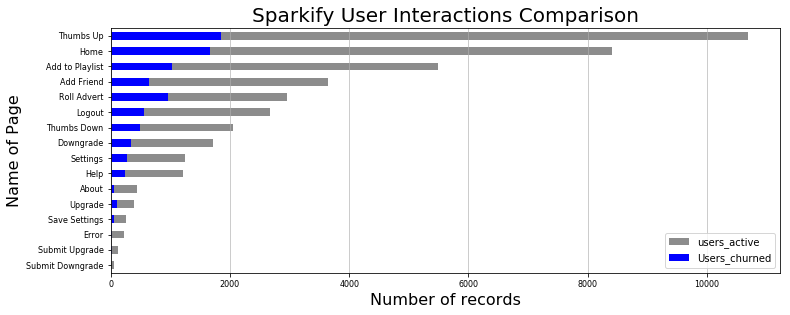

In [123]:
# Plotting user interactions for active and churned users
plt.title('Sparkify User Interactions Comparison', fontsize=20)

ax = pages_df['users_active'].plot(kind='barh', color ='0.55', figsize=(12, 4.5), legend=True, fontsize=10)

ax = pages_df['Users_churned'].plot(kind='barh', color ='b', legend=True, fontsize=8)
ax.set_ylabel("Name of Page", fontsize=16)
ax.set_xlabel("Number of records", fontsize=16)

# Displaying the plot
plt.grid(axis='x', alpha=0.8)
plt.show()


In [124]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [125]:
# Calculating statistics for user interactions based on churn status

interactions_statistics_df = spark.sql('''
      WITH page_counts AS( 
      SELECT userId, 
      MAX(Churn)                                                      AS Churn, 
      COUNT(CASE WHEN page = 'Thumbs Up'        THEN 1 ELSE null END) AS thumbs_up,
      COUNT(CASE WHEN page = 'Home'             THEN 1 ELSE null END) AS home,
      COUNT(CASE WHEN page = 'Add to Playlist'  THEN 1 ELSE null END) AS playlist_count, 
      COUNT(CASE WHEN page = 'Add Friend'       THEN 1 ELSE null END) AS friends,
      COUNT(CASE WHEN page = 'Roll Advert'      THEN 1 ELSE null END) AS advert,
      COUNT(CASE WHEN page = 'Logout'           THEN 1 ELSE null END) AS logout,
      COUNT(CASE WHEN page = 'Thumbs Down'      THEN 1 ELSE null END) AS thumbs_down,
      COUNT(CASE WHEN page = 'Downgrade'        THEN 1 ELSE null END) AS downgrade,
      COUNT(CASE WHEN page = 'Settings'         THEN 1 ELSE null END) AS settings,
      COUNT(CASE WHEN page = 'Help'             THEN 1 ELSE null END) AS help,
      COUNT(CASE WHEN page = 'About'            THEN 1 ELSE null END) AS about,
      COUNT(CASE WHEN page = 'Upgrade'          THEN 1 ELSE null END) AS upgrade,
      COUNT(CASE WHEN page = 'Save Settings'    THEN 1 ELSE null END) AS save_settings, 
      COUNT(CASE WHEN page = 'Error'            THEN 1 ELSE null END) AS error, 
      COUNT(CASE WHEN page = 'Submit Upgrade'   THEN 1 ELSE null END) AS submit_upgrade, 
      COUNT(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE null END) AS submit_downgrade,
      COUNT(DISTINCT sessionId)                                       AS session_count, 
      MAX (membership_duration_days)                                        AS membership_duration_days, 
      SUM(length/(60*60))                                             AS usage_hours 
      
      FROM user_log_data_view 
      GROUP BY userId) 
      SELECT Churn, 
      ROUND(AVG(thumbs_up),1)           AS thumbs_up,
      ROUND(AVG(home),1)                AS home,
      ROUND(AVG(playlist_count),1)      AS playlist_count, 
      ROUND(AVG(friends),1)             AS friends, 
      ROUND(AVG(advert),1)              AS advert, 
      ROUND(AVG(logout),1)              AS logout,
      ROUND(AVG(thumbs_down),1)         AS thumbs_down, 
      ROUND(AVG(downgrade),1)           AS downgrade, 
      ROUND(AVG(settings),1)            AS settings, 
      ROUND(AVG(help),1)                AS help, 
      ROUND(AVG(about),1)               AS about, 
      ROUND(AVG(upgrade),1)             AS upgrade,
      ROUND(AVG(save_settings),1)       AS save_settings,
      ROUND(AVG(error),1)               AS error, 
      ROUND(AVG(submit_upgrade),1)      AS submit_upgrade,
      ROUND(AVG(submit_downgrade),1)    AS submit_downgrade, 
      ROUND(AVG(session_count),1)       AS session_count,
      ROUND(AVG(membership_duration_days),1)     AS membership_duration_days,
      ROUND(AVG(usage_hours),1)         AS usage_hours
      
      FROM page_counts 
      GROUP BY Churn
      '''
      ).toPandas()

In [126]:
# Setting the 'Churn' column as the index for better representation
interactions_statistics_df = interactions_statistics_df.set_index('Churn')

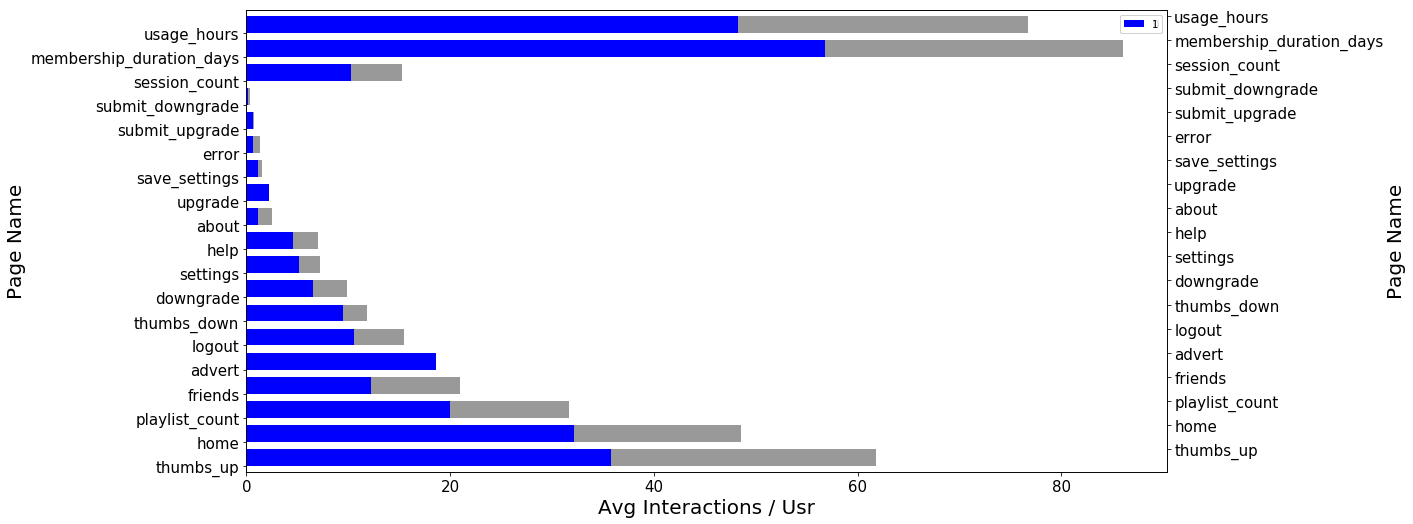

In [127]:
# Extracting the first two rows of the DataFrame and transposing it for plotting
df = interactions_statistics_df[0:2].transpose()

# Creating a matplotlib figure
fig = plt.figure()

# Creating matplotlib axes
ax = fig.add_subplot(111)
ax2 = ax.twinx()

# Setting the width of the bars
width = 0.7

# Plotting the bars for active users (Churn = 0) and churned users (Churn = 1)
df[0].plot(kind='barh', color='0.6', ax=ax, width=width, position=0, legend=True, fontsize=15)
df[1].plot(kind='barh', color='blue', ax=ax2, width=width, position=1, legend=True, fontsize=15)

# Setting labels and title
ax.set_xlabel('Avg Interactions / Usr', fontsize=20)
ax.set_ylabel('Page Name', fontsize=20)
ax2.set_ylabel('Page Name', fontsize=20)

# Setting the figure size
fig.set_size_inches(16.5, 8.5)

# Displaying the plot
plt.grid(axis='x', alpha=0.8)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


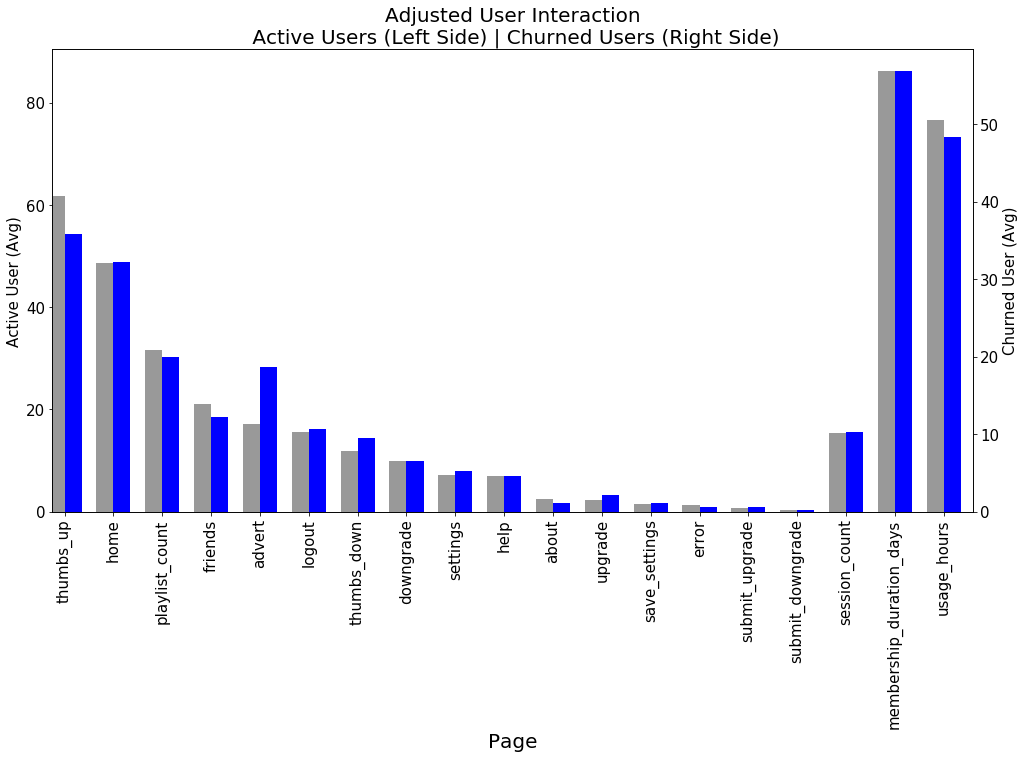

In [128]:
# Creating a matplotlib figure
fig = plt.figure()

# Setting the title
plt.title('Adjusted User Interaction\n Active Users (Left Side) | Churned Users (Right Side)', fontsize=20)

# Creating matplotlib axes
ax = fig.add_subplot(111)
ax2 = ax.twinx()

# Setting the width of the bars
width = 0.35

# Plotting the bars for active users (Churn = 0) and churned users (Churn = 1)
df[0].plot(kind='bar', color='0.6', ax=ax, width=width, position=1, legend=False, fontsize=15)
df[1].plot(kind='bar', color='blue', ax=ax2, width=width, position=0, legend=False, fontsize=15)

# Setting labels and title
ax.set_xlabel('Page', fontsize=20)
ax.set_ylabel('Active User (Avg)', fontsize=15)
ax2.set_ylabel('Churned User (Avg)', fontsize=15)

# Setting the figure size
fig.set_size_inches(16.5, 8.5)

# Displaying the plot
plt.grid(axis='x', alpha=0.8)
plt.show()


**Behavior Differences Analysis:**

Adjusting for days of membership and the number of sessions, the analysis reveals distinct patterns between active users and churned users:

- **Active Users:**
  - More frequent visits to the pages:
    - 'thumbs_up'
    - 'playlist_count'
    - 'friends'

- **Churned Users:**
  - More frequent visits to the pages:
    - 'advert'
    - 'thumbs_down'
    - 'upgrade'

In [129]:
# Transposing the relevant rows of the DataFrame for better visualization
interactions_statistics_df[0:2].transpose()

Churn,1,0
thumbs_up,35.8,61.8
home,32.2,48.6
playlist_count,20.0,31.7
friends,12.2,21.0
advert,18.6,17.1
logout,10.6,15.5
thumbs_down,9.5,11.8
downgrade,6.5,9.9
settings,5.2,7.2
help,4.6,7.0


In [130]:
# Registering a User Defined Function (UDF) named "get_hour" in Spark
# The UDF extracts the hour component from a timestamp
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

<function __main__.<lambda>(x)>

In [131]:
# Displaying the first row of the cleaned DataFrame
cleaned_df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', formatted_datetime='2018-11-21 18:12:32', formatted_registration_datetime='2018-09-27 02:45:40', membership_duration_days=55, churn_event=0, churn=0, downgrade_event=0, phase=0, items_number=381, city='Bridgeport-Stamford-Norwalk', state=' CT')]

In [132]:
# Extracting the hour from the timestamp for the first record using the UDF
spark.sql('''
          SELECT *, get_hour(ts) AS Hrs
          FROM user_log_data_view 
          LIMIT 1
          '''
          ).collect()

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', formatted_datetime='2018-11-21 18:12:32', formatted_registration_datetime='2018-09-27 02:45:40', membership_duration_days=55, churn_event=0, churn=0, downgrade_event=0, phase=0, items_number=381, city='Bridgeport-Stamford-Norwalk', state=' CT', Hrs='18')]

In [133]:
# Counting the number of songs played by active users in each hour
active_songs_on_hrs = spark.sql('''
          SELECT get_hour(ts) AS Hrs, COUNT(*) as A_usrs
          FROM user_log_data_view
          WHERE page = "NextSong" AND Churn = 0
          GROUP BY Hrs
          ORDER BY cast(Hrs as int) ASC
          '''
          ).toPandas()

In [134]:
# Counting the number of songs played by churn users in each hour
churn_songs_on_hrs = spark.sql('''
          SELECT get_hour(ts) AS Hrs, COUNT(*) as C_usrs
          FROM user_log_data_view
          WHERE page = "NextSong" AND Churn = 1
          GROUP BY Hrs
          ORDER BY cast(Hrs as int) ASC
          '''
          ).toPandas()

In [135]:
# Set the 'hour' column as the index for the 'active_songs_on_hrs' DataFrame
active_songs_on_hrs = active_songs_on_hrs.set_index('Hrs')   

# Set the 'hour' column as the index for the 'churn_songs_on_hrs' DataFrame
churn_songs_on_hrs = churn_songs_on_hrs.set_index('Hrs')   

# Concatenate the 'active_songs_on_hrs' and 'churn_songs_on_hrs' DataFrames horizontally based on the common 'hour' index
# This creates a new DataFrame 'hour_of_d' with columns from both DataFrames, where the index represents the hour of the day
hour_of_d = pd.concat([active_songs_on_hrs, churn_songs_on_hrs], axis=1, join="inner")

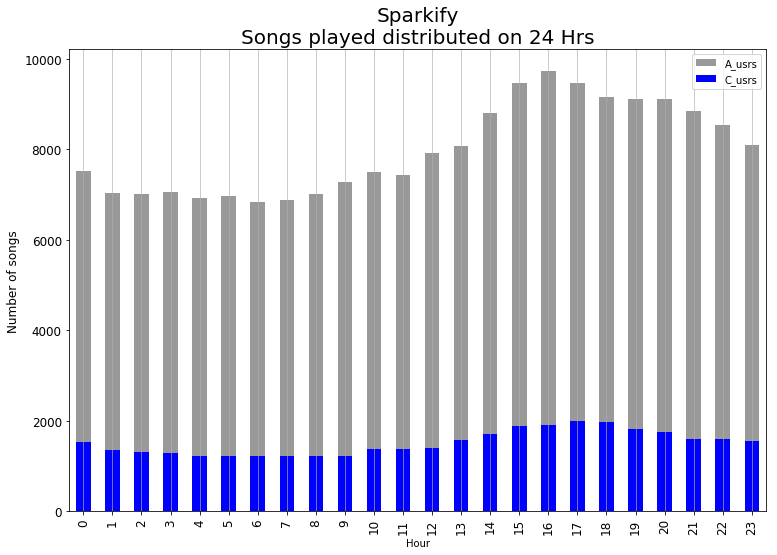

In [136]:
# Set the title for the plot
plt.title('Sparkify\nSongs played distributed on 24 Hrs', fontsize=20)

# Plot the 'active_users' column from the 'time_of_day' DataFrame as a bar chart
ax = hour_of_d['A_usrs'].plot(kind='bar', color ='0.6', figsize=(12.5, 8.5), legend=True, fontsize=15)

# Plot the 'churned_users' column from the 'time_of_day' DataFrame as a bar chart, overlaying it on the previous plot
ax = hour_of_d['C_usrs'].plot(kind='bar', color ='b', legend=True, fontsize=12)

# Set the X-axis label
ax.set_xlabel("Hour", fontsize=10)

# Set the Y-axis label
ax.set_ylabel("Number of songs", fontsize=12)

# Display the grid on the plot
plt.grid(axis='x', alpha=0.8)

# Show the plot
plt.show()

Generate new variables to represent time of day, day of the week, and the specific weekday.

### Creation of New Variables 'hour' & 'day' & 'weekday' & 'date'
(String)

hour : hour of the day for a record

day : day of the month for a record

weekday : weekday for the record

date: date for the record

In [137]:
# Define User-Defined Functions (UDFs)

# Extract hour of the day from timestamp
extract_hour_of_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# Extract day of the month as a zero-padded decimal number from timestamp
extract_day_of_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)

# Extract weekday as a decimal number (0 for Sunday, 6 for Saturday) from timestamp
extract_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

# Extract date in the format MM/DD/YYYY from timestamp
extract_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%m/%d/%Y'))

In [138]:
# Creation of new col. in the DataFrame

# Add a new column 'hour' representing the hour of the day
cleaned_df = cleaned_df.withColumn('hour', extract_hour_of_day(cleaned_df.ts))

# Add a new column 'day' representing the day of the month
cleaned_df = cleaned_df.withColumn('day', extract_day_of_month(cleaned_df.ts))

# Add a new column 'weekday' representing the weekday (0 for Sunday, 6 for Saturday)
cleaned_df = cleaned_df.withColumn('weekday', extract_weekday(cleaned_df.ts))

# Add a new column 'date' representing the date in the format MM/DD/YYYY
cleaned_df = cleaned_df.withColumn('date', extract_date(cleaned_df.ts))

In [139]:
# Display the first row of the cleaned DataFrame to inspect the transformed data
cleaned_df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', formatted_datetime='2018-11-21 18:12:32', formatted_registration_datetime='2018-09-27 02:45:40', membership_duration_days=55, churn_event=0, churn=0, downgrade_event=0, phase=0, items_number=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18', day='21', weekday='3', date='11/21/2018')]

In [140]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [141]:
# Extract active user counts per day of the month from the Spark DataFrame
active_dayOfMonth = spark.sql('''
          SELECT day AS d_of_m, COUNT(*) as users_active
          FROM user_log_data_view
          WHERE Churn == 0
          GROUP BY d_of_m
          ORDER BY cast(day as int) ASC
          '''
          ).toPandas()

In [142]:
# Extract churn user counts per day of the month from the Spark DataFrame
churn_dayOfMonth = spark.sql('''
          SELECT day AS d_of_m, COUNT(*) as Users_churned
          FROM user_log_data_view
          WHERE Churn == 1
          GROUP BY d_of_m
          ORDER BY cast(day as int) ASC
          '''
          ).toPandas()

In [143]:
# Set the 'd_of_m' column as the index for active_dayOfMonth DataFrame
active_dayOfMonth = active_dayOfMonth.set_index('d_of_m')   

# Set the 'd_of_m' column as the index for churn_dayOfMonth DataFrame
churn_dayOfMonth = churn_dayOfMonth.set_index('d_of_m')   

# Combine active_dayOfMonth and churn_dayOfMonth DataFrames using an outer join on the 'd_of_m' index
combined_dayOfMonth = pd.concat([active_dayOfMonth, churn_dayOfMonth], axis=1, join="outer")

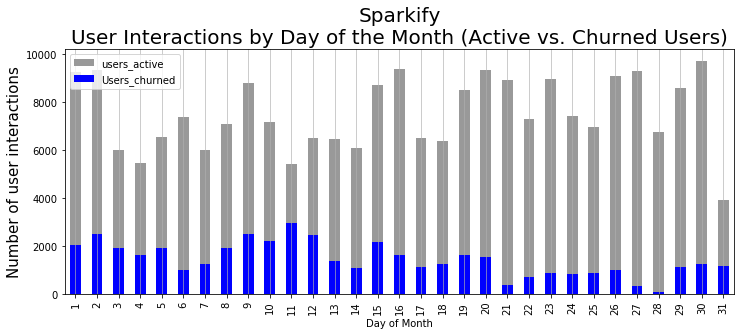

In [144]:
# Set the title for the plot
plt.title('Sparkify\nUser Interactions by Day of the Month (Active vs. Churned Users)', fontsize=20)

# Plot the 'active_users' data using a bar chart with specified settings
ax = combined_dayOfMonth['users_active'].plot(kind='bar', color='0.6', figsize=(12, 4.5), legend=True, fontsize=15)

# Plot the 'churned_users' data using a bar chart with specified settings
ax = combined_dayOfMonth['Users_churned'].plot(kind='bar', color='b', legend=True, fontsize=10)

# Set the x-axis label
ax.set_xlabel("Day of Month", fontsize=10)

# Set the y-axis label
ax.set_ylabel("Number of user interactions", fontsize=15)

# Enable grid on the plot
plt.grid(axis='x', alpha=0.8)

# Display the plot
plt.show()


In [145]:
# Extract active user counts per day of the week from the Spark DataFrame
active_dayOfWeek = spark.sql('''
          SELECT weekday AS d_of_w, COUNT(*) as users_active
          FROM user_log_data_view
          WHERE Churn == 0
          GROUP BY d_of_w
          ORDER BY cast(weekday as int) ASC
          '''
          ).toPandas()

In [146]:
# Extract churn user counts per day of the week from the Spark DataFrame
churn_dayOfWeek = spark.sql('''
          SELECT weekday AS d_of_w, COUNT(*) as Users_churned
          FROM user_log_data_view
          WHERE Churn == 1
          GROUP BY d_of_w
          ORDER BY cast(weekday as int) ASC
          '''
          ).toPandas()

In [147]:
# Set the 'd_of_w' column as the index for active_dayOfWeek DataFrame
active_dayOfWeek = active_dayOfWeek.set_index('d_of_w')   

# Set the 'd_of_w' column as the index for churn_dayOfWeek DataFrame
churn_dayOfWeek = churn_dayOfWeek.set_index('d_of_w')   

# Combine active_dayOfWeek and churn_dayOfWeek DataFrames using an outer join on the 'd_of_w' index
combined_dayOfWeek = pd.concat([active_dayOfWeek, churn_dayOfWeek], axis=1, join="outer")

In [148]:
# Mapping weekday 'd_of_w' numerical index to corresponding day names
d_of_w_mapping = {'0': 'Sunday', '1': 'Monday', '2': 'Tuesday', '3': 'Wednesday', '4': 'Thursday', '5': 'Friday', '6': 'Saturday'}

# Apply the mapping to the index of combined_dayOfWeek
combined_dayOfWeek.index = combined_dayOfWeek.index.map(d_of_w_mapping)

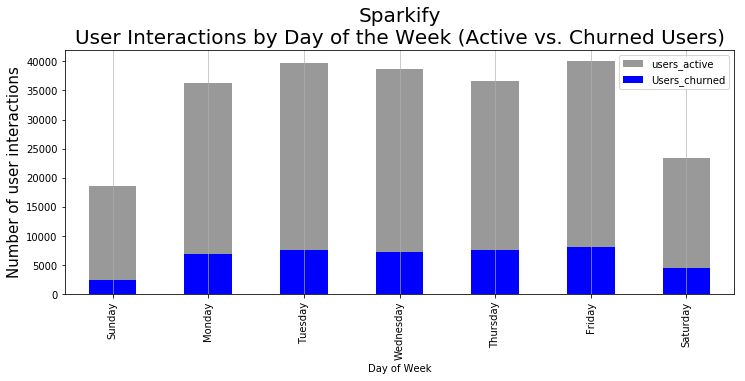

In [149]:
# Set the title for the plot
plt.title('Sparkify\nUser Interactions by Day of the Week (Active vs. Churned Users)', fontsize=20)

# Plot the active user interactions with a bar chart
ax = combined_dayOfWeek['users_active'].plot(kind='bar', color='0.6', figsize=(12, 4.5), legend=True, fontsize=15)

# Plot the churned user interactions with a bar chart
ax = combined_dayOfWeek['Users_churned'].plot(kind='bar', color='b', legend=True, fontsize=10)

# Set the x-axis label
ax.set_xlabel("Day of Week", fontsize=10)

# Set the y-axis label
ax.set_ylabel("Number of user interactions", fontsize=15)

# Display the grid on the plot
plt.grid(axis='x', alpha=0.8)

# Show the plot
plt.show()


In [150]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [151]:
# Extract active user counts based on date from the Spark DataFrame
active_date = spark.sql('''
          SELECT date, COUNT(*) as users_active
          FROM user_log_data_view
          WHERE Churn == 0
          GROUP BY date
          ORDER BY cast(date as int) DESC
          '''
          ).toPandas()

In [152]:
# Extract churn user counts based on date from the Spark DataFrame
churn_date = spark.sql('''
          SELECT date, COUNT(*) as Users_churned
          FROM user_log_data_view
          WHERE Churn == 1
          GROUP BY date
          ORDER BY cast(date as int) DESC
          '''
          ).toPandas()

In [153]:
# Set the 'date' column as the index for active_date DataFrame
active_date = active_date.set_index('date')   

# Set the 'date' column as the index for churn_date DataFrame
churn_date = churn_date.set_index('date')   

# Combine active_date and churn_date DataFrames using an outer join on the 'date' index
combined_date = pd.concat([active_date, churn_date], axis=1, join="outer", sort=True)

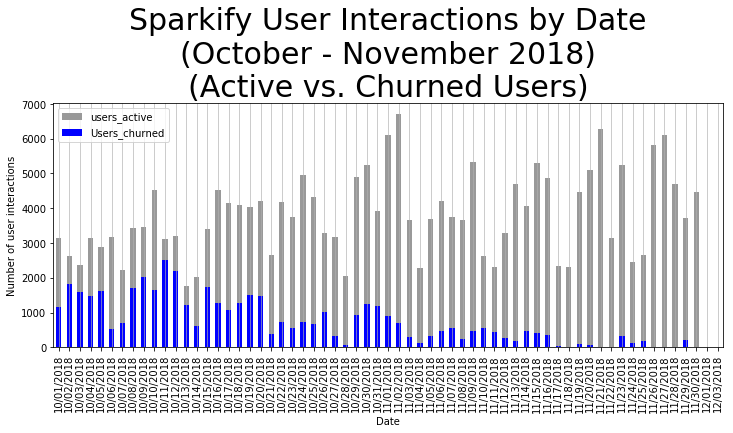

In [154]:
# Set the title for the plot
plt.title('Sparkify User Interactions by Date\n(October - November 2018)\n(Active vs. Churned Users)', fontsize=30)

# Plotting user interactions by date for active users in a bar chart
ax = combined_date['users_active'].plot(kind='bar', color='0.6', figsize=(12, 4.5), legend=True, fontsize=15)

# Plotting user interactions by date for churned users in a bar chart
ax = combined_date['Users_churned'].plot(kind='bar', color='b', legend=True, fontsize=10)

# Set the x-axis label for the plot
ax.set_xlabel("Date", fontsize=10)

# Set the y-axis label for the plot
ax.set_ylabel("Number of user interactions", fontsize=10)

# Display grid lines on the plot
plt.grid(axis='x', alpha=0.8)

# Display the plot
plt.show()


### Creation of a New Variables 'cohort_analysis'

In [155]:
# Define a User Defined Function (UDF) to extract the month and year from the registration timestamp
# and format it as 'MM/YYYY' and create a new variable "cohort_analysis"
getting_cohort_analysis = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%m/%Y'))

# Create a new column 'cohort' in the DataFrame to store the extracted cohort information
cleaned_df = cleaned_df.withColumn('cohort_analysis', getting_cohort_analysis(cleaned_df.registration))

# Display the first row of the cleaned DataFrame to inspect the transformed data
cleaned_df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', formatted_datetime='2018-11-21 18:12:32', formatted_registration_datetime='2018-09-27 02:45:40', membership_duration_days=55, churn_event=0, churn=0, downgrade_event=0, phase=0, items_number=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18', day='21', weekday='3', date='11/21/2018', cohort_analysis='09/2018')]

In [156]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [157]:
# Retrieve the count of distinct active users for each cohort
active_cohort_analysis = spark.sql('''
          SELECT cohort_analysis, COUNT(DISTINCT UserId) as users_active
          FROM user_log_data_view
          WHERE Churn == 0
          GROUP BY cohort_analysis
          ORDER BY cohort_analysis DESC
          '''
          ).toPandas()

In [158]:
# Retrieve the count of distinct churn users for each cohort
churn_cohort_analysis = spark.sql('''
          SELECT cohort_analysis, COUNT(DISTINCT UserId) as Users_churned
          FROM user_log_data_view
          WHERE Churn == 1
          GROUP BY cohort_analysis
          ORDER BY cohort_analysis DESC
          '''
          ).toPandas()

In [159]:
# Set the 'cohort_analysis' column as the index for active_cohort_analysis DataFrame
active_cohort_analysis = active_cohort_analysis.set_index('cohort_analysis')   

# Set the 'cohort_analysis' column as the index for churn_cohort_analysis DataFrame
churn_cohort_analysis = churn_cohort_analysis.set_index('cohort_analysis')   

# Combine active_cohort_analysis and churn_cohort_analysis DataFrames using an outer join on the 'cohort_analysis' index
combined_cohort_analysis = pd.concat([active_cohort_analysis, churn_cohort_analysis], axis=1, join="outer", sort=True)

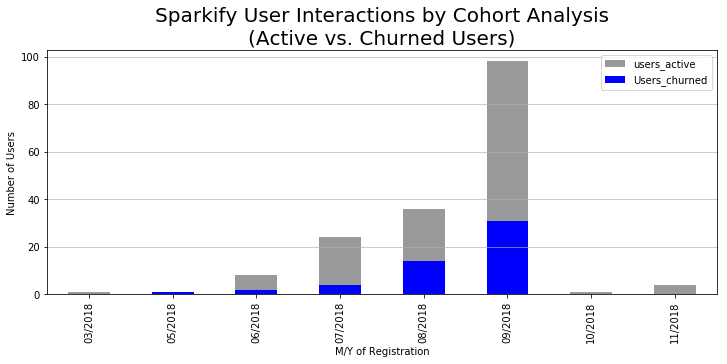

In [160]:
# Set the title for the plot
plt.title('Sparkify User Interactions by Cohort Analysis\n(Active vs. Churned Users)', fontsize=20)

# Plotting user interactions by Cohort Analysis for active users in a bar chart
ax = combined_cohort_analysis['users_active'].plot(kind='bar', color='0.6', figsize=(12, 4.5), legend=True, fontsize=15)

# Plotting user interactions by Cohort Analysis for churned users in a bar chart
ax = combined_cohort_analysis['Users_churned'].plot(kind='bar', color='b', legend=True, fontsize=10)

# Set the x-axis label for the plot
ax.set_xlabel("M/Y of Registration", fontsize=10)

# Set the y-axis label for the plot
ax.set_ylabel("Number of Users", fontsize=10)

# Display grid lines on the plot
plt.grid(axis='y', alpha=0.8)

# Display the plot
plt.show()

The majority of users in this dataset are affiliated with the cohorts from July 2018, August 2018, and September 2018.

### Variable 'userAgent'
(String)

The **userAgent** request header serves as a unique string that allows servers and network peers to identify the application, operating system, vendor, version.

In [161]:
# Count the number of records for each User-Agent in the dataset
counting_userAgent = spark.sql('''
    SELECT userAgent, COUNT(userId) AS Count_result
    FROM user_log_data_view
    GROUP BY userAgent
    ORDER BY Count_result DESC
''').toPandas()

In [162]:
# Displaying top 5 results for counting_userAgent DataFrame
counting_userAgent.head()

,userAgent,Count_result
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22751
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",19611
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",17348
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,16700


### Creation of New Variables 'mobile' & 'Apple_Mac' & 'Linux_Ubuntu' & 'Windows'
All are (Integer)
it can take (1 or 0)

1 encoding True
0 encoding False

In [163]:
# User-Defined Functions (UDFs) to flag the type of device based on userAgent

# detection for mobile devices
detection_mobile = udf(lambda x: 1 if 'Mobi' in x else 0, IntegerType())
cleaned_df = cleaned_df.withColumn("mobile", detection_mobile(cleaned_df.userAgent))

# detection for Apple Mac devices (excluding mobile)
detection_Apple_Mac = udf(lambda x: 1 if 'Mac' in x and not 'Mobi' in x else 0, IntegerType())
cleaned_df = cleaned_df.withColumn("Apple_Mac", detection_Apple_Mac(cleaned_df.userAgent))

# detection for Ubuntu/Linux devices (excluding mobile)
detection_Ubuntu = udf(lambda x: 1 if 'Ubuntu' in x or 'Linux' in x and not 'Mobi' in x else 0, IntegerType())
cleaned_df = cleaned_df.withColumn("Linux_Ubuntu", detection_Ubuntu(cleaned_df.userAgent))

# detection for Windows devices (excluding mobile and Ubuntu/Linux)
detection_Windows = udf(lambda x: 1 if 'Windows' in x and not 'Mobi' in x and not 'Ubuntu' in x else 0, IntegerType())
cleaned_df = cleaned_df.withColumn("Windows", detection_Windows(cleaned_df.userAgent))

In [164]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

In [165]:
# Retrieve count the number of distinct users who accessed Sparkify using mobile devices, grouped by churn status
mobile_users = spark.sql('''
    SELECT COUNT(DISTINCT userId) AS mobile_users, Churn
    FROM user_log_data_view
    WHERE mobile == 1
    GROUP BY Churn
''').toPandas()

In [166]:
# Retrieve count the number of distinct users who accessed Sparkify using Apple_Mac devices, grouped by churn status
Apple_Mac_users = spark.sql('''
    SELECT COUNT(DISTINCT userId) AS Apple_Mac, Churn
    FROM user_log_data_view
    WHERE Apple_Mac == 1
    GROUP BY Churn
''').toPandas()

In [167]:
# Retrieve count the number of distinct users who accessed Sparkify using Linux devices, grouped by churn status
Linux_users = spark.sql('''
    SELECT COUNT(DISTINCT userId) AS Linux_users, Churn
    FROM user_log_data_view
    WHERE Linux_Ubuntu == 1
    GROUP BY Churn
''').toPandas()

In [168]:
# Retrieve count the number of distinct users who accessed Sparkify using mobile devices, grouped by churn status
Windows_users = spark.sql('''
    SELECT COUNT(DISTINCT userId) AS Windows_users, Churn
    FROM user_log_data_view
    WHERE Windows == 1
    GROUP BY Churn
''').toPandas()

In [169]:
# Set the 'Churn' column as the index for the mobile_users DataFrame
mobile_users.set_index('Churn', inplace=True)

# Set the 'Churn' column as the index for the Apple_Mac_users DataFrame
Apple_Mac_users.set_index('Churn', inplace=True)

# Set the 'Churn' column as the index for the Linux_users DataFrame
Linux_users.set_index('Churn', inplace=True)

# Set the 'Churn' column as the index for the Windows_users DataFrame
Windows_users.set_index('Churn', inplace=True)

In [170]:
# Combining the User Interaction Data for Different User Agents
devices_combined = pd.concat([mobile_users, Apple_Mac_users, Linux_users, Windows_users], axis=1, join="inner")

In [171]:
# Mapping Churn labels to meaningful categories for better visualization
encoding_churn = {0:'users_active', 1:'Users_churned'}

# Mapping the Churn labels to meaningful categories for better visualization
devices_combined.index = devices_combined.index.map(encoding_churn)

# Showing the DataFrame
devices_combined

,mobile_users,Apple_Mac,Linux_users,Windows_users
Churn,,,,
Users_churned,4,19,5,24
users_active,12,67,7,87


In [172]:
# Printing the columns of the combined devices DataFrame
print(devices_combined.columns)

Index(['mobile_users', 'Apple_Mac', 'Linux_users', 'Windows_users'], dtype='object')


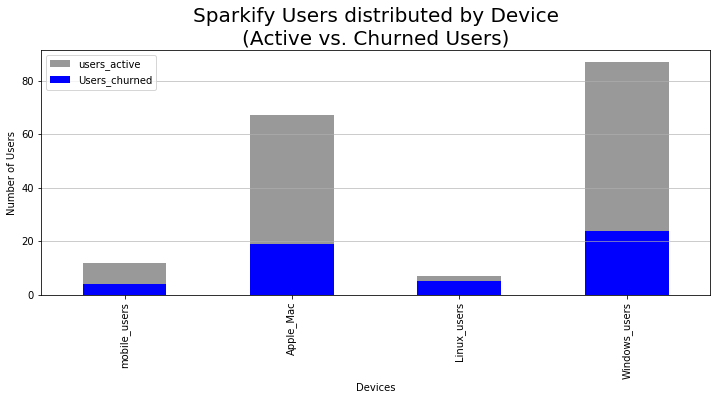

In [173]:
# Set the title for the plot
plt.title('Sparkify Users distributed by Device\n(Active vs. Churned Users)', fontsize=20)

# Plotting user interactions by device for active users in a bar chart
ax = devices_combined.iloc[1].plot(kind='bar', color='0.6', figsize=(12, 4.5), legend=True, fontsize=15)

# Plotting user interactions by device for churned users in a bar chart
ax = devices_combined.iloc[0].plot(kind='bar', color='b', legend=True, fontsize=10)

# Set the x-axis label for the plot
ax.set_xlabel("Devices", fontsize=10)

# Set the y-axis label for the plot
ax.set_ylabel("Number of Users", fontsize=10)

# Display grid lines on the plot
plt.grid(axis='y', alpha=0.8)

# Display the plot
plt.show()

The majority of Sparkify users access the platform using either desktop or laptop on Windows Operating System computers.

In [174]:
# Printing the Schema of the cleaned_df DataFrame
print(cleaned_df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- formatted_datetime: string (nullable = true)
 |-- formatted_registration_datetime: string (nullable = true)
 |-- membership_duration_days: integer (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- p

In [175]:
# Show first Row of cleaned_df DataFrame
cleaned_df.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', formatted_datetime='2018-11-21 18:12:32', formatted_registration_datetime='2018-09-27 02:45:40', membership_duration_days=55, churn_event=0, churn=0, downgrade_event=0, phase=0, items_number=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18', day='21', weekday='3', date='11/21/2018', cohort_analysis='09/2018', mobile=1, Apple_Mac=0, Linux_Ubuntu=0, Windows=0)]

In [176]:
# Convert the 'weekday' column to integer type
cleaned_df = cleaned_df.withColumn("weekday", cleaned_df["weekday"].cast(IntegerType()))

# Convert the 'hour' column to integer type
cleaned_df = cleaned_df.withColumn("hour", cleaned_df["hour"].cast(IntegerType()))

# Convert the 'userId' column to integer type
cleaned_df = cleaned_df.withColumn("userId", cleaned_df["userId"].cast(IntegerType()))

# Convert the 'day' column to integer type
cleaned_df = cleaned_df.withColumn("day", cleaned_df["day"].cast(IntegerType()))

In [177]:
# Refresh our temp view
cleaned_df.createOrReplaceTempView("user_log_data_view")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [184]:
# Extracting user features using Spark SQL

user_features = spark.sql(
    '''
    SELECT 
    userId, 
    MAX(Churn) AS label,  -- Target variable indicating churn
    COUNT(CASE WHEN page = 'Error' THEN 1 ELSE null END) AS error_count,  -- Number of error events
    COUNT(CASE WHEN page = 'Add Friend' THEN 1 ELSE null END) AS friends_count,  -- Number of friend additions
    COUNT(CASE WHEN page = 'Roll Advert' THEN 1 ELSE null END) AS advert_count,  -- Number of advertisement interactions
    COUNT(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE null END) AS playlist_count,  -- Number of playlist additions
    COUNT(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE null END) AS thumbs_up,  -- Number of thumbs-up interactions
    COUNT(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE null END) AS thumbs_down,  -- Number of thumbs-down interactions
    COUNT(CASE WHEN page = 'Downgrade' THEN 1 ELSE null END) AS downgrade,  -- Number of downgrade events
    COUNT(CASE WHEN page = 'Upgrade' THEN 1 ELSE null END) AS upgrade,  -- Number of upgrade events
    COUNT(CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE null END) AS submit_upgrade,  -- Number of submit upgrade events
    COUNT(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE null END) AS submit_downgrade,  -- Number of submit downgrade events
        
        
    INT(CASE WHEN FIRST (level) ='free' THEN True ELSE False END) AS FIRST_level_free,  -- Flag indicating if the first level is free
    INT(CASE WHEN FIRST (level) ='paid' THEN True ELSE False END) AS FIRST_level_paid,  -- Flag indicating if the first level is paid
    INT(CASE WHEN LAST (level) ='free' THEN True ELSE False END) AS LAST_level_free,  -- Flag indicating if the last level is free
    INT(CASE WHEN LAST (level) ='paid' THEN True ELSE False END) AS LAST_level_paid,  -- Flag indicating if the last level is paid
        
        
    SUM(downgrade_event) AS phase,  -- Total number of downgrade events
    MAX(mobile) AS mobile,  -- Maximum value for mobile flag
    MAX(Apple_Mac) AS Apple_Mac,  -- Maximum value for Apple Mac flag
    MAX(Linux_Ubuntu) AS Linux,  -- Maximum value for Linux Ubuntu flag
    MAX(Windows) AS Windows,  -- Maximum value for Windows flag
    AVG(hour) AS hour,  -- Average hour of user activity
    AVG(day) AS day,  -- Average day of user activity
    AVG(weekday) AS weekday,  -- Average weekday of user activity
        
        
    INT(MAX(CASE WHEN cohort_analysis = '05/2018' THEN True ELSE False END)) AS cohort_May18,  -- Flag indicating May 2018 cohort
    INT(MAX(CASE WHEN cohort_analysis = '06/2018' THEN True ELSE False END)) AS cohort_Jun18,  -- Flag indicating June 2018 cohort
    INT(MAX(CASE WHEN cohort_analysis = '07/2018' THEN True ELSE False END)) AS cohort_Jul18,  -- Flag indicating July 2018 cohort
    INT(MAX(CASE WHEN cohort_analysis = '08/2018' THEN True ELSE False END)) AS cohort_Aug18,  -- Flag indicating August 2018 cohort
    INT(MAX(CASE WHEN cohort_analysis = '09/2018' THEN True ELSE False END)) AS cohort_Sep18,  -- Flag indicating September 2018 cohort
    INT(MAX(CASE WHEN gender = 'F' THEN True ELSE False END)) AS female,  -- Flag indicating female gender
    INT(MAX(CASE WHEN state = ' CA' THEN True ELSE False END)) AS CA,  -- Flag indicating California state
    INT(MAX(CASE WHEN state = ' TX' THEN True ELSE False END)) AS TX,  -- Flag indicating Texas state
    INT(MAX(CASE WHEN state = ' FL' THEN True ELSE False END)) AS FL,  -- Flag indicating Florida state
    INT(MAX(CASE WHEN state = ' NY-NJ-PA' THEN True ELSE False END)) AS NY_NJ_PA,  -- Flag indicating NY-NJ-PA state
        
        
    MAX (membership_duration_days) AS membership_duration_days,  -- Maximum number of days of membership
    COUNT(DISTINCT sessionId) AS session_count,  -- Number of unique sessions
    MAX(items_number) AS items_count,  -- Maximum number of items in a session
    COUNT(CASE WHEN page = 'NextSong' THEN 1 ELSE null END) AS song_count,  -- Number of songs played
    SUM(length/(60*60)) AS usage_hours  -- Total usage hours
        
        
    FROM user_log_data_view 
    GROUP BY userId
    '''
)

In [185]:
# Create or replace a temporary view for 'user_features'
user_features.createOrReplaceTempView('user_features')

# Remove rows with missing values (NaN or null) from the 'user_features' DataFrame
user_features = user_features.na.drop()

# The 'user_features' DataFrame is now ready for further processing without missing values

In [186]:
# Convert the Spark DataFrame 'user_features' to a Pandas DataFrame
df_user_features = user_features.toPandas()

In [187]:
# Transpose the Pandas DataFrame 'user_features'
df_user_features.transpose()

# The DataFrame 'transposed_user_features' now represents the transpose of 'user_features'
# Transposing swaps rows with columns, providing a different view of the data

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
userId,148.000000,85.000000,137.000000,65.000000,200001.000000,53.000000,133.000000,100003.000000,200021.000000,78.000000,...,18.000000,74.000000,138.000000,200005.000000,104.000000,134.000000,36.000000,200002.000000,89.000000,300022.000000
label,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
error_count,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
friends_count,7.000000,58.000000,8.000000,53.000000,0.000000,25.000000,1.000000,0.000000,19.000000,2.000000,...,10.000000,43.000000,41.000000,3.000000,23.000000,0.000000,35.000000,4.000000,14.000000,11.000000
advert_count,32.000000,33.000000,10.000000,8.000000,3.000000,25.000000,1.000000,9.000000,11.000000,16.000000,...,0.000000,22.000000,17.000000,5.000000,23.000000,3.000000,34.000000,7.000000,13.000000,0.000000
playlist_count,5.000000,108.000000,4.000000,68.000000,3.000000,46.000000,3.000000,2.000000,30.000000,9.000000,...,14.000000,80.000000,67.000000,5.000000,43.000000,2.000000,23.000000,8.000000,12.000000,9.000000
thumbs_up,28.000000,192.000000,8.000000,111.000000,10.000000,69.000000,2.000000,3.000000,55.000000,11.000000,...,20.000000,135.000000,95.000000,7.000000,84.000000,3.000000,53.000000,21.000000,30.000000,25.000000
thumbs_down,3.000000,38.000000,1.000000,17.000000,1.000000,16.000000,0.000000,0.000000,35.000000,3.000000,...,1.000000,25.000000,24.000000,0.000000,17.000000,1.000000,12.000000,6.000000,6.000000,5.000000
downgrade,0.000000,42.000000,0.000000,20.000000,0.000000,13.000000,0.000000,0.000000,26.000000,0.000000,...,3.000000,31.000000,21.000000,0.000000,24.000000,0.000000,3.000000,5.000000,2.000000,1.000000
upgrade,3.000000,7.000000,4.000000,3.000000,1.000000,5.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,3.000000,1.000000,2.000000,3.000000,1.000000,7.000000,2.000000,2.000000,0.000000


In [188]:
# statistical summary of the Pandas DataFrame 'user_features'
df_user_features.describe()

,userId,label,error_count,friends_count,advert_count,playlist_count,thumbs_up,thumbs_down,downgrade,upgrade,...,female,CA,TX,FL,NY_NJ_PA,membership_duration_days,session_count,items_count,song_count,usage_hours
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,65391.013333,0.231111,1.120000,19.008889,17.480000,29.004444,55.782222,11.315556,9.133333,2.217778,...,0.462222,0.146667,0.071111,0.062222,0.066667,79.364444,14.115556,1236.240000,1013.813333,70.155089
std,105396.477919,0.422483,1.472607,20.581717,21.550207,32.716654,65.477925,13.077481,11.734412,2.558537,...,0.499682,0.354562,0.257583,0.242097,0.250000,37.646625,14.646885,1329.531716,1104.960779,76.499001
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,3.000000,0.192130
25%,60.000000,0.000000,0.000000,5.000000,3.000000,6.000000,11.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,6.000000,296.000000,230.000000,16.009215
50%,116.000000,0.000000,1.000000,14.000000,11.000000,17.000000,35.000000,7.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000,10.000000,848.000000,675.000000,46.692719
75%,100017.000000,0.000000,2.000000,27.000000,22.000000,44.000000,81.000000,16.000000,13.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,18.000000,1863.000000,1571.000000,109.000415
max,300025.000000,1.000000,7.000000,143.000000,128.000000,240.000000,437.000000,75.000000,73.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,256.000000,107.000000,9632.000000,8002.000000,553.098588


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### (1st): Train-Test Split

In this initial step, we perform the train-test split operation to partition the dataset into distinct subsets for training and testing purposes. The primary objective is to create a training set to train a machine learning model and a separate testing set for evaluating its performance. This common practice involves allocating a certain percentage of the data for training and reserving the remainder for testing. The separation ensures an unbiased assessment of the model's predictive capabilities by training it on one subset and evaluating it on another.

In [189]:
# Splitting the dataset for Training and Validation
# Using the randomSplit method to the user_features DataFrame
# 80% of the data will be used for training (train), and 20% will be used for testing (test)
# A random seed value of 42 is set for reproducibility

train, test = user_features.randomSplit([0.8, 0.2], seed=42)

In [190]:
# Obtaining the Count of Records in the testing Set
# The count() method is applied to the 'test' DataFrame to determine the number of records in the testing set.
test.count()

45

### (2nd): Creating a Feature's Vector

In this crucial step, we move forward by creating a feature vector that consolidates and organizes the relevant features from the dataset. This process involves selecting and assembling specific attributes or columns from the dataset to form a cohesive set of features that will serve as input for the machine learning model.

The selection of features is often based on their relevance to the predictive task, and careful consideration is given to include meaningful information while excluding unnecessary or redundant data. Feature engineering techniques may also be applied at this stage to enhance the model's ability to extract valuable insights from the chosen features.

Once the feature vector is constructed, it acts as the input for training and validating the machine learning model. The quality and relevance of the features play a pivotal role in determining the model's performance, making this step a critical aspect of the overall machine learning pipeline.


In [203]:
# Initializing VectorAssembler for Feature Vector Construction
# The VectorAssembler is a PySpark feature that combines specified input columns into a single feature vector.
# The 'feature_assembler' object is created to handle this assembly process.

feature_assembler = VectorAssembler(
    inputCols=[
        "userId",
        "error_count",
        "friends_count",
        "advert_count",
        "playlist_count",
        "thumbs_up",
        "thumbs_down",
        "downgrade",
        "upgrade",
        "submit_upgrade",
        "submit_downgrade",
        "FIRST_level_paid",
        "LAST_level_paid",
        "phase",
        "mobile",
        "Apple_Mac",
        "Linux",
        "Windows",
        "hour",
        "day",
        "weekday",
        "cohort_May18",
        "cohort_Jun18",
        "cohort_Jul18",
        "cohort_Aug18",
        "cohort_Sep18",
        "female",
        "CA",
        "TX",
        "FL",
        "NY_NJ_PA",
        "membership_duration_days",
        "session_count",
        "items_count",
        "song_count",
        "usage_hours"
    ],
    outputCol="inputFeatures"
)
# The 'inputCols' parameter lists the column names to be included in the feature vector.
# The 'outputCol' parameter specifies the name of the resulting feature vector column.

## (3rd): Normalizing Vectors

In this pivotal step, we proceed with the normalization of the feature vectors. Normalization is a crucial preprocessing technique that ensures uniformity in the scale of different features, preventing certain features from dominating others during the training process.

Normalization involves transforming the values of the feature vectors to a standardized scale, often within the range of [0, 1]. This is particularly important when dealing with machine learning algorithms that are sensitive to the scale of input features, such as distance-based models.

The `MinMaxScaler` or other normalization techniques may be employed in this step to achieve consistent scaling across all features in the dataset. The resulting normalized feature vectors are then ready to be utilized for training and evaluating machine learning models, contributing to improved model stability and performance.

In [204]:
# Initializing Normalizer for Feature Vector Normalization
# The Normalizer is a PySpark feature that scales each feature vector to have unit norm (L2 norm by default).
# The 'feature_normalizer' object is created to handle this normalization process.

feature_normalizer = Normalizer(
    inputCol="inputFeatures",   # Specifies the input feature vector column
    outputCol="features"  # Specifies the output column for normalized feature vectors
)

## (4th): Building The Pipelines for Streamlined Workflow

In this integral step, we advance towards the construction of pipelines to streamline the end-to-end machine learning workflow. A pipeline encapsulates a sequence of data processing and modeling steps, providing a convenient and organized approach to building, training, and deploying machine learning models.

The process involves assembling a series of stages, such as feature vector creation, normalization, and model training, into a cohesive pipeline. Each stage is meticulously designed to transform or analyze the data in a structured manner.

Pipelines offer several advantages, including code reusability, maintainability, and the ability to systematically apply the same set of transformations across different datasets. Additionally, they enhance reproducibility by ensuring consistency in the sequence of operations.

To illustrate, PySpark's `Pipeline` class is commonly utilized for this purpose, allowing for the seamless integration of various stages into a unified and efficient machine learning workflow.


I'll choose **four** algorithms:

* Logistic regression
* Random forest classifier
* Gradient-boosted tree classifier
* Linear Support Vector Machine

In [205]:
# Logistic Regression Model
# Initialize a Logistic Regression model with specified parameters
logistic_regression = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

# Construct a pipeline for Logistic Regression
# The pipeline incorporates the processes of feature vector assembly, normalization, and logistic regression modeling
pipeline_lr = Pipeline(stages=[feature_assembler, feature_normalizer, logistic_regression])

# Random Forest Classifier Model
# Initialize a Random Forest Classifier model
random_forest_classifier = RandomForestClassifier()

# Construct a pipeline for Random Forest Classifier
# The pipeline includes feature vector assembly, normalization, and random forest classification
pipeline_rf = Pipeline(stages=[feature_assembler, feature_normalizer, random_forest_classifier])

# Gradient-Boosted Tree Classifier Model
# Initialize a Gradient-Boosted Tree Classifier model
gradient_boosted_tree = GBTClassifier()

# Construct a pipeline for Gradient-Boosted Tree Classifier
# The pipeline involves feature vector assembly, normalization, and gradient-boosted tree classification
pipeline_gbt = Pipeline(stages=[feature_assembler, feature_normalizer, gradient_boosted_tree])

# Linear Support Vector Machine Model
# Initialize a Linear Support Vector Machine model
linear_svm = LinearSVC()

# Construct a pipeline for Linear Support Vector Machine
# The pipeline includes feature vector assembly, normalization, and linear SVM modeling
pipeline_svm = Pipeline(stages=[feature_assembler, feature_normalizer, linear_svm])


###  Logistic regression

Model Tuning as a start

In this phase, we aim to fine-tune the logistic regression model for optimal performance. Utilizing the initial 80% of the dataset, we employ a 3-fold cross-validation approach to identify the most accurate logistic regression model.

The tuning process involves exploring a parameter grid with specific values for the LogisticRegression regularization parameter, considering both 0.0 and 0.1. Additionally, we focus on optimizing the LogisticRegression model's max iteration number, setting it to 10 for this analysis. The goal is to discover the combination of hyperparameters that yields the highest accuracy, enhancing the overall effectiveness of the logistic regression model.


In [206]:
# Hyperparameter Grid for Model Tuning
# Building a parameter grid using ParamGridBuilder to explore different combinations
# We focus on two hyperparameters: 'regParam' for regularization and 'maxIter' for the maximum number of iterations
# The grid includes values [0.0, 0.1] for 'regParam' and [10] for 'maxIter'
param_grid = ParamGridBuilder()\
    .addGrid(logistic_regression.regParam, [0.0, 0.1])\
    .addGrid(logistic_regression.maxIter, [10])\
    .build()

# Model Evaluator
# Utilizing the F1 score as the evaluation metric for multiclass classification
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# Cross-Validation Setup
# Initializing CrossValidator with the logistic regression pipeline, parameter grid, and evaluator
# The process involves 3-fold cross-validation for robust model assessment
cross_validator = CrossValidator(
    estimator=pipeline_lr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3
)

In [207]:
# Timing the Model Fitting Process
# Record the starting time before fitting the logistic regression cross-validation model
start_time = time.time()

# Fit the logistic regression cross-validation model on the training set ('train' subset)
cv_model_logistic_regression = cross_validator.fit(train)

# Record the ending time after model fitting
end_time = time.time()

# Calculate and print the elapsed time for model fitting
elapsed_time = end_time - start_time
print(f'The Model Fitting Process is {elapsed_time} seconds')

Model fitting took 562.955729007721 seconds


In [210]:
# Extracting the average metrics computed during cross-validation for the logistic regression model
cv_model_logistic_regression.avgMetrics

[0.6844739119231689, 0.6675305954526793]

In [211]:
# Applying the logistic regression cross-validated model to the testing dataset
results_logistic_regression = cv_model_logistic_regression.transform(test)

###  Logistic regression | Model Evaluation: Accuracy & F1 Score

In [213]:
#Accuracy

# Counting the number of true positive predictions
true_positive_count = results_logistic_regression.filter(results_logistic_regression.label == results_logistic_regression.prediction).count()

# Counting the total number of predictions
total_predictions_count = results_logistic_regression.count()

# Calculating and printing the accuracy
accuracy = true_positive_count / total_predictions_count
print(f'True Positives: {true_positive_count} out of {total_predictions_count} predictions.')
print(f'Accuracy: {accuracy:.2%}')

True Positives: 34 out of 45 predictions.
Accuracy: 75.56%


In [215]:
#F1 Score

# Evaluating the Logistic Regression model on the test set using the specified evaluator
test_evaluation = evaluator.evaluate(cv_model_logistic_regression.transform(test))

# Displaying the evaluation metric (default: F1 score)
print(f'Test Set Evaluation: {test_evaluation:.4f}')

Test Set Evaluation: 0.7009


###  Random forest classifier
Model Tuning as a start

In [216]:
# Defining the parameter grid for Random Forest
paramgrid_rf = ParamGridBuilder().build()

# Creating a MulticlassClassificationEvaluator with the F1 score as the evaluation metric
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# Setting up CrossValidator for Random Forest with the specified pipeline, parameter grid, evaluator, and number of folds
cross_validator_rf = CrossValidator(estimator=pipeline_rf,
                              estimatorParamMaps=paramgrid_rf,
                              evaluator=evaluator,
                              numFolds=3
                            )

In [218]:
# Timing the Model Fitting Process
# Record the starting time before fitting the random forest cross-validation model
start_time = time.time()

# Fit the random forest cross-validation model on the training set ('train' subset)
cv_model_random_forest = cross_validator_rf.fit(train)

# Record the ending time after model fitting
end_time = time.time()

# Calculate and print the elapsed time for model fitting
elapsed_time = end_time - start_time
print(f'The Model Fitting Process is {elapsed_time} seconds')

The Model Fitting Process is 543.1464035511017 seconds


In [219]:
# Applying the trained Random Forest model to the test dataset
results_random_forest = cv_model_random_forest.transform(test)

###  Random Forest | Model Evaluation: Accuracy & F1 Score

In [220]:
# Accuracy

# Counting the number of true positive predictions
true_positive_count = results_random_forest.filter(results_random_forest.label == results_random_forest.prediction).count()

# Counting the total number of predictions
total_predictions_count = results_random_forest.count()

# Calculating and printing the accuracy
accuracy = true_positive_count / total_predictions_count
print(f'True Positives: {true_positive_count} out of {total_predictions_count} predictions.')
print(f'Accuracy: {accuracy:.2%}')

True Positives: 32 out of 45 predictions.
Accuracy: 71.11%


In [221]:
# F1 Score

# Evaluating the Random Forest model on the test set using the specified evaluator
test_evaluation = evaluator.evaluate(cv_model_random_forest.transform(test))

# Displaying the evaluation metric (default: F1 score)
print(f'Test Set Evaluation: {test_evaluation:.4f}')

Test Set Evaluation: 0.6465


### Gradient-boosted Tree classifier
Model Tuning as a start

In [224]:
# Defining the parameter grid for Gradient-boosted Tree classifier
param_grid_gbt = ParamGridBuilder().build()

# Creating a MulticlassClassificationEvaluator with the F1 score as the evaluation metric
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# Setting up CrossValidator for Gradient-boosted Tree classifier with the specified pipeline, parameter grid, evaluator, and number of folds
cross_validator_gbt = CrossValidator(estimator=pipeline_gbt,
                              estimatorParamMaps=param_grid_gbt,
                              evaluator=evaluator,
                              numFolds=3
                            )

In [225]:
# Timing the Model Fitting Process
# Record the starting time before fitting the Gradient-boosted Tree classifier cross-validation model
start_time = time.time()

# Fit the Gradient-boosted Tree classifier cross-validation model on the training set ('train' subset)
cv_model_gbt = cross_validator_gbt.fit(train)

# Record the ending time after model fitting
end_time = time.time()

# Calculate and print the elapsed time for model fitting
elapsed_time = end_time - start_time
print(f'The Model Fitting Process is {elapsed_time} seconds')

The Model Fitting Process is 1278.4388172626495 seconds


In [226]:
# Applying the trained Gradient-boosted Tree classifier model to the test dataset
results_gbt = cv_model_gbt.transform(test)

###  Gradient-boosted Tree classifier | Model Evaluation: Accuracy & F1 Score

In [227]:
# Accuracy

# Counting the number of true positive predictions
true_positive_count = results_gbt.filter(results_gbt.label == results_gbt.prediction).count()

# Counting the total number of predictions
total_predictions_count = results_gbt.count()

# Calculating and printing the accuracy
accuracy = true_positive_count / total_predictions_count
print(f'True Positives: {true_positive_count} out of {total_predictions_count} predictions.')
print(f'Accuracy: {accuracy:.2%}')

True Positives: 33 out of 45 predictions.
Accuracy: 73.33%


In [228]:
# F1 Score

# Evaluating the Gradient-boosted Tree classifier model on the test set using the specified evaluator
test_evaluation = evaluator.evaluate(cv_model_gbt.transform(test))

# Displaying the evaluation metric (default: F1 score)
print(f'Test Set Evaluation: {test_evaluation:.4f}')

Test Set Evaluation: 0.7072


### Linear Support Vector Machine

Model Tuning as a start

In [229]:
# Defining the parameter grid for Linear Support Vector Machine
param_grid_lsvm = ParamGridBuilder().build()

# Creating a MulticlassClassificationEvaluator with the F1 score as the evaluation metric
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# Setting up CrossValidator for Linear Support Vector Machine with the specified pipeline, parameter grid, evaluator, and number of folds
cross_validator_lsvm = CrossValidator(estimator=pipeline_svm,
                              estimatorParamMaps=param_grid_lsvm,
                              evaluator=evaluator,
                              numFolds=3
                            )

In [230]:
# Timing the Model Fitting Process
# Record the starting time before fitting the Linear Support Vector Machine cross-validation model
start_time = time.time()

# Fit the Linear Support Vector Machine cross-validation model on the training set ('train' subset)
cv_model_lsvm = cross_validator_lsvm.fit(train)

# Record the ending time after model fitting
end_time = time.time()

# Calculate and print the elapsed time for model fitting
elapsed_time = end_time - start_time
print(f'The Model Fitting Process is {elapsed_time} seconds')

The Model Fitting Process is 2902.1836833953857 seconds


In [231]:
# Applying the trained Linear Support Vector Machine model to the test dataset
results_lsvm = cv_model_lsvm.transform(test)

###  Linear Support Vector Machine | Model Evaluation: Accuracy & F1 Score

In [232]:
# Accuracy

# Counting the number of true positive predictions
true_positive_count = results_lsvm.filter(results_lsvm.label == results_lsvm.prediction).count()

# Counting the total number of predictions
total_predictions_count = results_lsvm.count()

# Calculating and printing the accuracy
accuracy = true_positive_count / total_predictions_count
print(f'True Positives: {true_positive_count} out of {total_predictions_count} predictions.')
print(f'Accuracy: {accuracy:.2%}')

True Positives: 33 out of 45 predictions.
Accuracy: 73.33%


In [233]:
# F1 Score

# Evaluating the Linear Support Vector Machine model on the test set using the specified evaluator
test_evaluation = evaluator.evaluate(cv_model_lsvm.transform(test))

# Displaying the evaluation metric (default: F1 score)
print(f'Test Set Evaluation: {test_evaluation:.4f}')

Test Set Evaluation: 0.6867


# In Closing

In Conclusion, We will be comparing the **four** models based on:
* Accuracy
* F1 Score 
* Time to train (Secs)

And they are as follows:

| Model Name | Accuracy | F1 Score | Time to train (Secs) |
|----------|----------|----------|----------|
| Logistic Regression | 75.56% | 70.09% | 562.95 Secs |
| Random Forest classifier | 71.11% | 64.65% | 543.14 Secs |
| Gradient-boosted Tree classifier | 73.33% | 70.72% | 1278.43 Secs |
| Linear Support Vector Machine | 73.33% | 68.67% | 2902.18 Secs |

The best performing model is Logistic Regression, with an Accuracy of 75.56%, F1 Score of 70.09%, and a training time of 562.95 Secs on the testing set.

The Sparkify churn prediction model aims to pinpoint users for targeted promotions or interventions to retain their subscription. Yet, caution is needed to avoid mistakenly labeling loyal users as potential churn risks, as providing discounts or promotions is costly and should be directed at users genuinely at risk of leaving.

To boost model performance, a more concentrated effort on cohort analysis is recommended. Analyzing user behavior throughout their lifecycle can provide insights into the timing of churn decisions, ultimately improving the model's predictive accuracy.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.